## Imports and definitions

In [1]:
import datetime
import functools
import os

import numpy as np
import pandas as pd

import sklearn.dummy
import sklearn.ensemble
import sklearn.model_selection
import sklearn.neighbors
import sklearn.linear_model
import sklearn.metrics

from scipy.special import softmax
import scipy.stats
import surprise

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['text.usetex'] = True

import sys
import lvml
from lvml.experiment import *


Seed rng:

In [2]:
RANDOM_STATE = int(os.environ.get('RANDOM_STATE',0))

lvml.random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
print(f'Random state={RANDOM_STATE}')

Random state=0


In [3]:
INPUT_DATASET = os.environ.get('INPUT_DATASET','movielens')
print(f'Dataset={INPUT_DATASET}')

Dataset=movielens


Track computation start:

In [4]:
global_start_time = datetime.datetime.now()

In [5]:
param_tracker = ExperimentParamTracker()
param = param_tracker.declare_param
get_param = param_tracker.get_param

param(RANDOM_STATE, 'random_state')

0

## Collaborative Filtering

### Data split and training

In [6]:
with print_progress('Loading dataset'):
    if INPUT_DATASET=='movielens':
        dataset = surprise.Dataset.load_builtin('ml-1m')
    elif INPUT_DATASET=='goodreads':
        dataset_path = os.path.expanduser(
            '~/Documents/lvml/datasets/goodreads/goodreads_interactions_comics_graphic.csv'
        )
        dataset = surprise.Dataset.load_from_file(
            file_path=dataset_path,
            reader=surprise.Reader(
                line_format='user item rating',
                sep=',',
                rating_scale=(1,5),
                skip_lines=1,
            )
        )
    else:
        raise ValueError(f'Uknown dataset: {INPUT_DATASET}')

cf_training_set, cf_test_set = stratified_train_test_split(
    dataset,
    train_size=param(0.3, 'cf_training_set_size'),
    random_state=RANDOM_STATE,
)
print(f'{cf_training_set.n_ratings} ratings in CF training set, {len(cf_test_set)} ratings in CF test set.')
n_users = param(len({uid for uid,iid,r,t in dataset.raw_ratings}), 'cf_n_users')
n_items = param(len({iid for uid,iid,r,t in dataset.raw_ratings}), 'cf_n_items')
print(f'n_users={n_users}, n_items={n_items}')

with print_progress('Fitting factorization model'):
    n_factors = param(8, 'cf_n_factors')
    cf_model = surprise.SVD(
        biased=True,
        n_factors=n_factors,
        random_state=RANDOM_STATE,
    )
    cf_model.fit(cf_training_set)

with print_progress('Calculating predictions'):
    rating_predictions = cf_model.test(cf_test_set)

cf_rmse = surprise.accuracy.rmse(rating_predictions, verbose=False)
param(cf_rmse, 'cf_rmse')
print(f'RMSE={cf_rmse:.3f}')

Loading dataset... Done (0:00:01.154386)
300086 ratings in CF training set, 700123 ratings in CF test set.
n_users=6040, n_items=3706
Fitting factorization model... Done (0:00:00.626071)
Calculating predictions... Done (0:00:03.690459)
RMSE=0.917


Gather rating predictions for each user, discarding impossible predictions:

In [7]:
user_predictions = [list() for iuid in range(cf_training_set.n_users)]
impossible_predictions = []
for pred in rating_predictions:
    iuid = cf_training_set.to_inner_uid(pred.uid)
    if not pred.details['was_impossible']:
        user_predictions[iuid].append(pred)
    else:
        impossible_predictions.append(pred)
user_predictions = np.array(user_predictions, dtype=object)

if impossible_predictions:
    print(
        f'{len(impossible_predictions)} impossible predictions discarded.\n'
        f'There are {len(rating_predictions)} predictions in total,'
        f' discarded {len(impossible_predictions)/len(rating_predictions):.2%} of all predictions.'
    )
else:
    print(
        'Rating predictions can be made for all user-item pairs in the test set.'
    )
    
assert sum(len(p) for p in user_predictions)==len(cf_test_set)

Rating predictions can be made for all user-item pairs in the test set.


## LV simulators

### Instantiate simulators

In [8]:
lv_base = lvml.LotkaVolterraDynamicalSystem(
    alpha=param(1.3,'lv_alpha'),
    beta=param((np.arange(5)+1)**2/5, 'lv_beta'),
    gamma=param(2e-1,'lv_gamma'),
    delta=param(1e-2,'lv_delta'),
)

stateless_base = lvml.StatelessBehavioralModel(
    tau=param(4, 'stateless_model_tau'),
)

kappa_values = param([0.0,0.5,1.0],'kappa_values')
discrete_simulation_batch_size = param(10, 'discrete_simulation_batch_size')

simulators = {
    (sim_name,kappa): sim_cls(
        kappa=kappa,
        random_state=RANDOM_STATE,
    )
    for sim_name, sim_cls in {
        'lv_equilibrium': functools.partial(
            EquilibriumEmpiricalRateSimulator,
            behavioral_model=lv_base,
        ),
        'discrete': functools.partial(
            DiscreteEmpiricalRateSimulator,
            behavioral_model=lv_base,
            simulator_params=dict(
                batch_size=discrete_simulation_batch_size,
                record_events=False,
            )
        ),
        'stateless': functools.partial(
            DiscreteEmpiricalRateSimulator,
            behavioral_model=stateless_base,
            simulator_params=dict(
                batch_size=discrete_simulation_batch_size,
                record_events=False,
            )
        )
    }.items()
    for kappa in kappa_values
}

### User latent parameters class

In [9]:
user_params_rng = surprise.utils.get_rng(RANDOM_STATE)

user_params = np.array(
    [
        LatentUserParameters(
            iuid=iuid,
            predictions=user_predictions[iuid],
            lv=lv_base,
            softmax_t=param(0.5, 'softmax_t'),
            simulation_length=param(100,'simulation_length'),
            rng=user_params_rng,
        )
        for iuid in range(len(user_predictions))
    ],
    dtype=object
)

### Construct feature vector

In [10]:
def average_est_rating_user(user, softmax_t):
    est_ratings = user.predicted_ratings()
    return (est_ratings*softmax(est_ratings/softmax_t)).sum()

average_est_rating_vec = lambda softmax_t: np.array(
    [average_est_rating_user(user, softmax_t)
     for user in user_params]
)

X = np.hstack([
    np.array(cf_model.pu),  # user factors
    np.expand_dims(np.array(cf_model.bu), axis=1),  # user bias
    np.expand_dims(average_est_rating_vec(softmax_t=get_param('softmax_t')), axis=1),  # average rating estimate
])

assert X.shape==(n_users, n_factors+2)

## Engagement gains upper bound

Gain upper bound: 7.82%


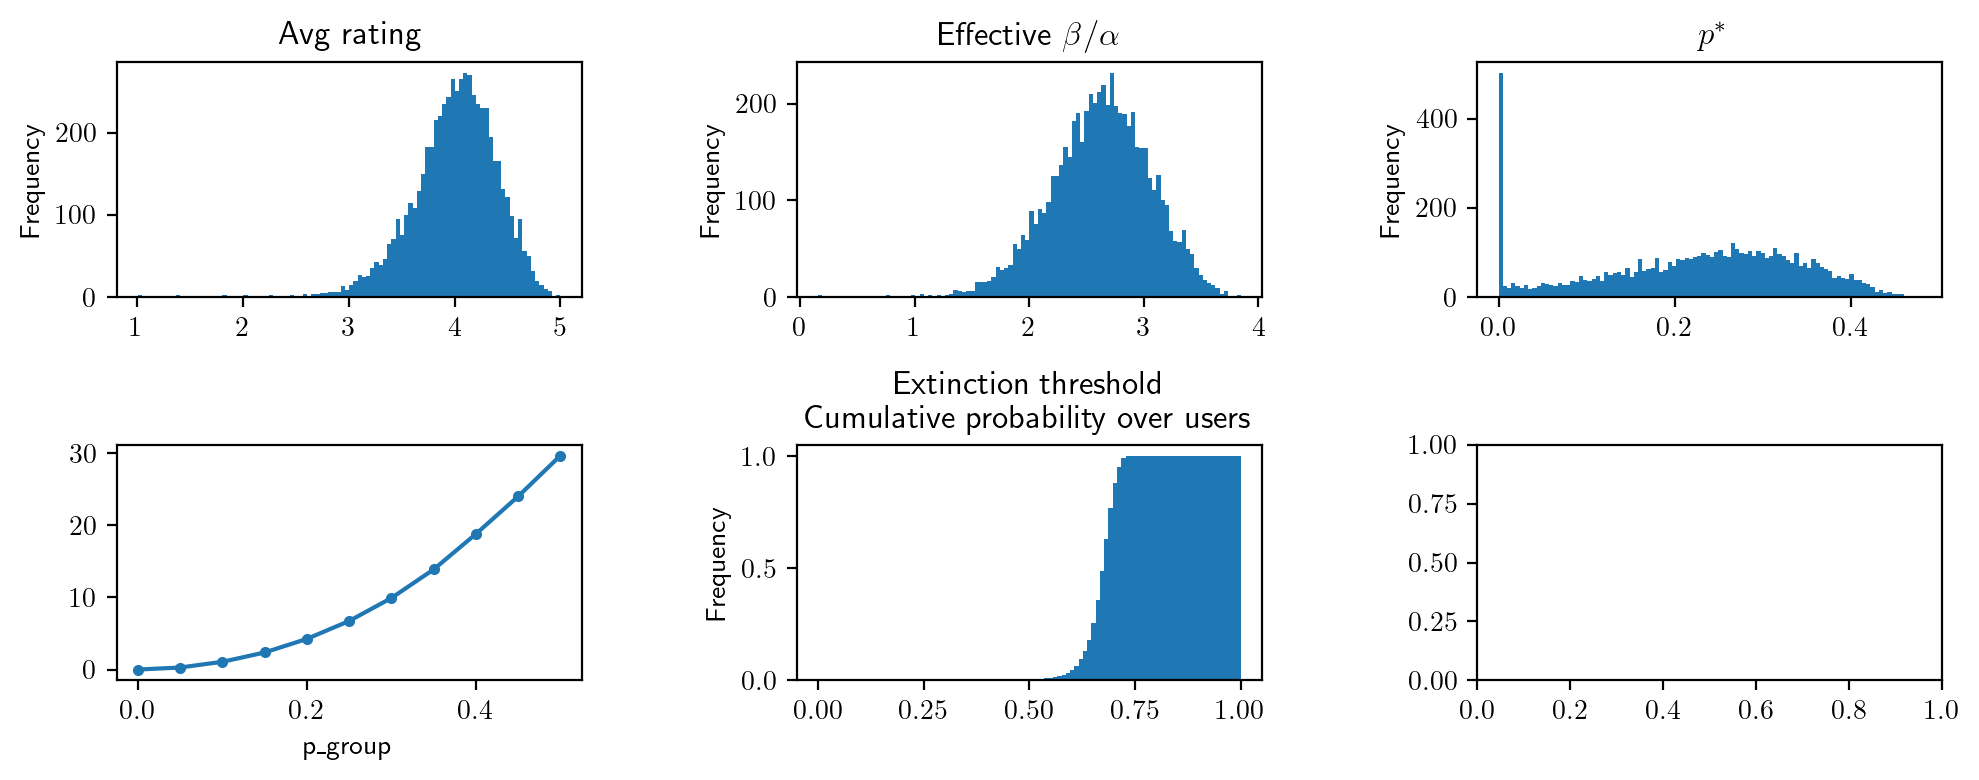

In [11]:


selected_simulator = ('lv_equilibrium',0.0)

upperbound_df = (
    pd.DataFrame([
        {
            'avg_rating': u.build_rec(0,selected_simulator[1]).rating_probabilities()@np.arange(1,6),
            'alpha': lv_base.alpha,
            'beta': u.build_rec(0,selected_simulator[1]).effective_beta(lv_base),
            'gamma': lv_base.gamma,
            'delta': lv_base.delta,
            'n_predictions': len(pred),
        }
        for u in user_params
    ])
    .assign(
        myopic_eq = lambda df: df.apply(
            lambda row: myopic_eq_f(row['alpha']/row['beta'], row['gamma']/row['delta']),
            axis=1,
        ),
        p_opt = lambda df: df.apply(
            lambda row: p_opt_f(row['alpha']/row['beta']),
            axis=1,
        ),
        opt_eq = lambda df: df.apply(
            lambda row: opt_eq_f(row['alpha']/row['beta'], row['gamma']/row['delta']),
            axis=1,
        ),
    )
)

print(f"Gain upper bound: {upperbound_df['opt_eq'].sum()/upperbound_df['myopic_eq'].sum()-1:.2%}")

fig,axs=plt.subplots(2,3,figsize=(10,4))
ax=axs.ravel()[0]
(
    upperbound_df['avg_rating']
    .plot.hist(
        title=r'Avg rating',
        bins=100,
        ax=ax,
    )
)

ax=axs.ravel()[1]
(
    (upperbound_df['beta']/upperbound_df['alpha'])
    .plot.hist(
        title=r'Effective $\beta/\alpha$',
        bins=100,
        ax=ax,
    )
)

ax=axs.ravel()[2]
(
    upperbound_df['p_opt']
    .plot.hist(
        title='$p^*$',
        bins=100,
        ax=ax,
    )
)

ax=axs.ravel()[3]
(
    upperbound_df
    .assign(
        p_group=lambda df: quantize(df['p_opt'], 0.05),
    )
    .groupby('p_group')
    .mean()
    .assign(
        gain=lambda df: df['opt_eq']/df['myopic_eq']-1,
    )
    ['gain']
    .apply(lambda s: s*100)
    .plot.line(marker='.', ax=ax)
)

ax=axs.ravel()[4]
(
    pd.Series([
        (
            simulators[selected_simulator]
            .evaluate_for_user(0,u)['avg_rating']
        )
        for u in user_params
    ])
    .apply(lambda b: 1-lv_base.alpha/b)
    .plot.hist(
        bins=np.linspace(0,1,100),
        density=True,
        cumulative=True,
        title='Extinction threshold\nCumulative probability over users',
        xlabel='p(break)',
        ylabel=r'Proportion of users with $\lambda^*(p;u)=0$',
        ax=ax,
    )
)

fig.tight_layout(w_pad=4)

## Data split for supervised models

Divide users to train and evaluation sets:

In [12]:
X_train, X_eval, users_train, users_eval = sklearn.model_selection.train_test_split(
    X,
    user_params,
    test_size=param(1000,'evaluation_set_users'),
    random_state=RANDOM_STATE,
    shuffle=True,
)


print('X array shapes:')
for arr_name, arr in {'X':X, 'X_train':X_train, 'X_eval':X_eval}.items():
    print(f'{arr_name}: {arr.shape}')
print()

X array shapes:
X: (6040, 10)
X_train: (5040, 10)
X_eval: (1000, 10)



Assign treatments within training set:

In [13]:
# treatments = [0.0,0.05,0.1,0.15]
# treatments = [0.0,0.05,0.1,0.15,0.3,0.4]

treatments = param([0.0,0.05,0.1,0.15], 'main_experiment_treatments')

def treatments_split(treatments):
    control_group_size = param(0.7, 'control_group_weight')
    treatment_weights = [control_group_size] + [(1-control_group_size)/(len(treatments)-1)]*(len(treatments)-1)
    treatment_weights_dct = {p: w for p,w in zip(treatments, treatment_weights)}
    treatment_weights_cdf=(np.array(treatment_weights)/sum(treatment_weights)).cumsum()

    train_idx = np.arange(len(X_train))
    train_groups = np.split(train_idx, (treatment_weights_cdf*len(X_train)).round().astype(int)[:-1])

    _treatment_datasets = {
        p: (X_train[grp_idx], users_train[grp_idx])
        for p, grp_idx in zip(treatments, train_groups)
    }
    assert len(X_train)==sum([len(X) for p,(X,preds) in _treatment_datasets.items()])
    print('Array shapes for each treatment group:')
    for p in treatments:
        print(f'{p}: {_treatment_datasets[p][0].shape}')
    group_weights=np.array(treatment_weights)/sum(treatment_weights)
    print('Group weights:',group_weights)    
    return _treatment_datasets

treatment_datasets = treatments_split(treatments)

Array shapes for each treatment group:
0.0: (3528, 10)
0.05: (504, 10)
0.1: (504, 10)
0.15: (504, 10)
Group weights: [0.7 0.1 0.1 0.1]


In [14]:
(
    upperbound_df
    .assign(
        argmax_eq = lambda df: df['beta'].map(lambda b: max(
            lv_eq_f(lv_base.alpha/b, lv_base.gamma/lv_base.delta, p)
            for p in treatments
        )),
    )
    [['opt_eq','argmax_eq','myopic_eq']]
    .mean()
    .pipe(lambda s: s/s.loc['myopic_eq'])
    
)

opt_eq       1.078216
argmax_eq    1.048755
myopic_eq    1.000000
dtype: float64

## Supervised prediction

### Training

In [15]:
supervised_prediction_algs = {
    'gradient_boosting': functools.partial(
        sklearn.ensemble.GradientBoostingRegressor,
        random_state=RANDOM_STATE,
    ),
    'linear_regression': sklearn.linear_model.LinearRegression,
    'dummy': functools.partial(
        sklearn.dummy.DummyRegressor,
        strategy='mean',
    ),
}

predictor_names = list(supervised_prediction_algs)+['oracle']

In [16]:
def learn_engagement_predictors(treatment_datasets):
    with print_progress('Building training sets'):
        training_sets = {
            (sim_name, p): (X, simulator.empirical_rate_from_users_vec(p_fb=p, users=users))
            for p,(X,users) in treatment_datasets.items()
            for sim_name,simulator in simulators.items()
        }
    
    with print_progress('Training supervised predictors'):
        predictors = {
            (pred_name, sim_name, p): pred_constructor().fit(X,y)
            for (sim_name,p),(X,y) in training_sets.items()
            for pred_name, pred_constructor in supervised_prediction_algs.items()
        }
    
    with print_progress('Fitting KNN oracle predictor'):
        predictors.update({
            ('oracle', (sim_name,kappa), p): (
                sklearn.neighbors.KNeighborsRegressor(n_neighbors=1)
                .fit(
                    X_eval,
                    simulators[(sim_name,kappa)].empirical_rate_from_users_vec(p_fb=p, users=users_eval),
#                     np.mean(np.vstack([
                        
#                         for k in range(param(5,'oracle_prediction_num_repetitions'))
#                     ]), axis=0)
                    # simulators[('lv_equilibrium',kappa)].empirical_rate_from_users_vec(p_fb=p, users=users_eval),
                )
            )
            for p, _ in treatment_datasets.items()
            for (sim_name,kappa), simulator in simulators.items()
        })
        
    predictor_funcs = {
        tup: pred_obj.predict
        for tup, pred_obj in predictors.items()
    }
    return predictor_funcs

predictor_funcs = learn_engagement_predictors(treatment_datasets)
    

Building training sets... Done (0:00:37.964703)
Training supervised predictors... Done (0:00:10.133875)
Fitting KNN oracle predictor... Done (0:00:28.945670)


### RMSE

In [17]:
with print_progress('Calculating evaluation-set consumption for each treatment'):
    eval_set_consumption = {
        (sim_name, p): simulators[sim_name].empirical_rate_from_users_vec(p_fb=p, users=users_eval)
        for sim_name in simulators
        for p in treatments
    }

Calculating evaluation-set consumption for each treatment... Done (0:00:26.675802)


In [18]:
with print_progress('Calculating RMSE on evaluation set'):
    predictor_rmse = {
        (pred_name, sim_name, p): sklearn.metrics.mean_squared_error(
            y_true=eval_set_consumption[(sim_name,p)],
            y_pred=f(X_eval),
            squared=False,
        )
        for (pred_name, sim_name, p), f in predictor_funcs.items()
    }

rmse_df = pd.DataFrame([
    {
        'simulator': sim_name,
        'predictor': pred_name,
        'p_fb': p,
        'rmse': rmse,
    }
    for (pred_name, sim_name, p), rmse in predictor_rmse.items()
])

Calculating RMSE on evaluation set... Done (0:00:00.107307)


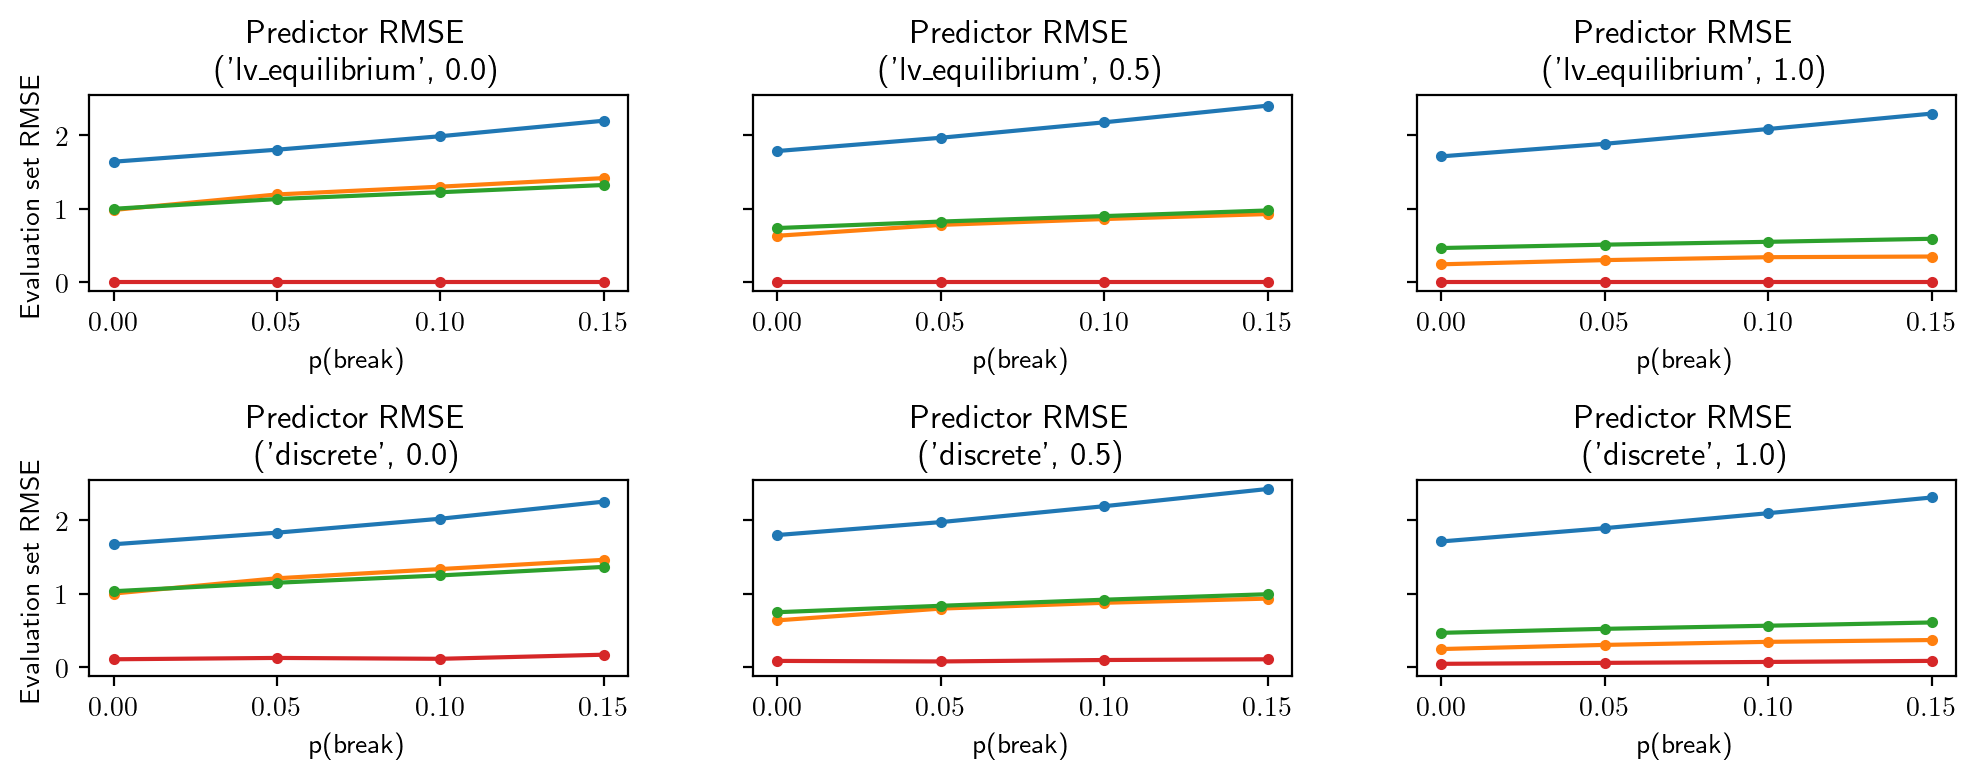

In [19]:
fig,axs = plt.subplots(2,3,figsize=(10,4),sharey=True)
for sim_name,ax in zip(simulators,axs.ravel()):
    (
        rmse_df
        .query('simulator==@sim_name')
        .pivot('p_fb','predictor','rmse')
        .plot.line(
            ax=ax,
            marker='.',
            legend=False,
        )
    )
    ax.set(
        title=f'Predictor RMSE\n{sim_name}',
        ylabel='Evaluation set RMSE',
        xlabel='p(break)',
    )
    # ax.legend(None)
fig.tight_layout(w_pad=4)

<AxesSubplot:title={'center':'Prediction RMSE as a function of $\\kappa$ \n $p_\\mathrm{break}=0.1$'}, xlabel='$\\kappa$', ylabel='RMSE'>

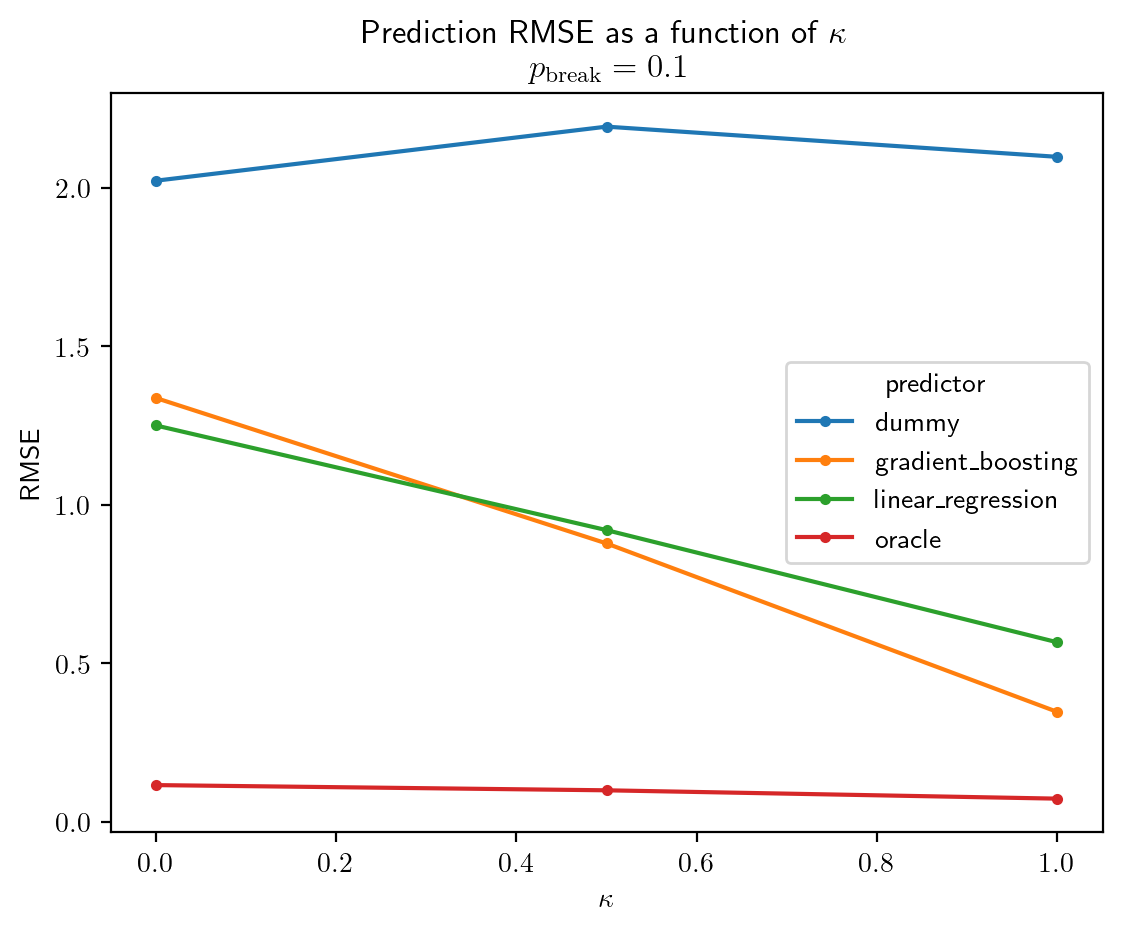

In [20]:
selected_p_fb = 0.1
(
    rmse_df
    .assign(
        sim_name=lambda df: df['simulator'].map(lambda t:t[0]),
        kappa=lambda df: df['simulator'].map(lambda t:t[1]),
    )
    .query('sim_name=="discrete" and p_fb==@selected_p_fb')
    .pivot('kappa','predictor','rmse')
    .plot.line(
        marker='.',
        title='Prediction RMSE as a function of $\kappa$ \n $p_\mathrm{break}='+f'{selected_p_fb}$',
        xlabel='$\kappa$',
        ylabel='RMSE',
    )
)

## Policy optimization

### Select optimized policies

In [21]:
policies = {
    'lv_engagement': functools.partial(lvml.LotkaVolterraOptimalForcedBreaksPolicy, max_p=0.5),
    'argmax': lvml.ArgmaxForcedBreaksPolicy,
    'myopic': lvml.MyopicForcedBreaksPolicy,
}

with print_progress('Policy selection'):
    policy_optimizers = {
        (policy_name, pred_name, sim_name): (
            policy_cls(
                predictors={
                    p: f
                    for (prd, sim, p), f in predictor_funcs.items()
                    if prd==pred_name and sim==sim_name
                },
            )
        )
        for policy_name, policy_cls in policies.items()
        for pred_name in predictor_names
        for sim_name in simulators
    }
    
    chosen_policy = {
        tup: optimizer.p_forced_break(X_eval)
        for tup, optimizer in policy_optimizers.items()
    }

Policy selection... Done (0:00:10.603352)


### Evaluate chosen policies

In [22]:
with print_progress('Calculating engagement for chosen policies'):
    policy_equilibrium = {
        (policy_name, pred_name, sim_name): (
            simulators[sim_name]
            .evaluate_from_users_personalized(p_fb_vec=p_break, users=users_eval)
        )
        for (policy_name, pred_name, sim_name), p_break in chosen_policy.items()
    }

Calculating engagement for chosen policies... Done (0:01:26.868954)


## Analysis of results

### Create results dataframe

In [23]:
results_df = pd.DataFrame([
    {
        'simulator': sim_name[0],
        'kappa': sim_name[1],
        'predictor': pred_name,
        'policy': policy_name,
        'user_ind': i,
        'p_fb': chosen_policy[(policy_name, pred_name, sim_name)][i],
        **policy_equilibrium[(policy_name, pred_name, sim_name)][i],
    }
    for sim_name in simulators
    for pred_name in predictor_names
    for policy_name in policies
    for i in range(len(X_eval))
])
results_df

,simulator,kappa,predictor,policy,user_ind,p_fb,rate,avg_rating,survival_pct
0,lv_equilibrium,0.0,gradient_boosting,lv_engagement,0,0.334601,13.136320,4.063835,1.000000
1,lv_equilibrium,0.0,gradient_boosting,lv_engagement,1,0.156428,12.716809,3.959998,1.000000
2,lv_equilibrium,0.0,gradient_boosting,lv_engagement,2,0.361739,12.680488,4.062166,1.000000
3,lv_equilibrium,0.0,gradient_boosting,lv_engagement,3,0.500000,3.522329,3.586651,1.000000
4,lv_equilibrium,0.0,gradient_boosting,lv_engagement,4,0.266196,13.591384,4.133038,1.000000
...,...,...,...,...,...,...,...,...,...
107995,stateless,1.0,oracle,myopic,995,0.000000,17.190000,4.302327,0.999599
107996,stateless,1.0,oracle,myopic,996,0.000000,18.130000,4.537452,0.999877
107997,stateless,1.0,oracle,myopic,997,0.000000,14.040000,3.517165,0.999408
107998,stateless,1.0,oracle,myopic,998,0.000000,16.610000,4.157857,0.999492


In [24]:
assert len(results_df.query('avg_rating>5+1e-3'))==0

### Extinction

In [25]:
(
    results_df
    .query('simulator=="discrete" and kappa==0.0')
    .assign(survived=lambda df: df['survival_pct']>0.8)
    .groupby(['predictor','policy'])
    ['survived']
    .value_counts()
    .unstack()
    .unstack()
)
    

survived           False                        True                     
policy            argmax lv_engagement myopic argmax lv_engagement myopic
predictor                                                                
dummy                  6             8      3    994           992    997
gradient_boosting      4            13      3    996           987    997
linear_regression      4             3      3    996           997    997
oracle                 3             2      3    997           998    997

### Decision histogram

Chosen policies histogram:

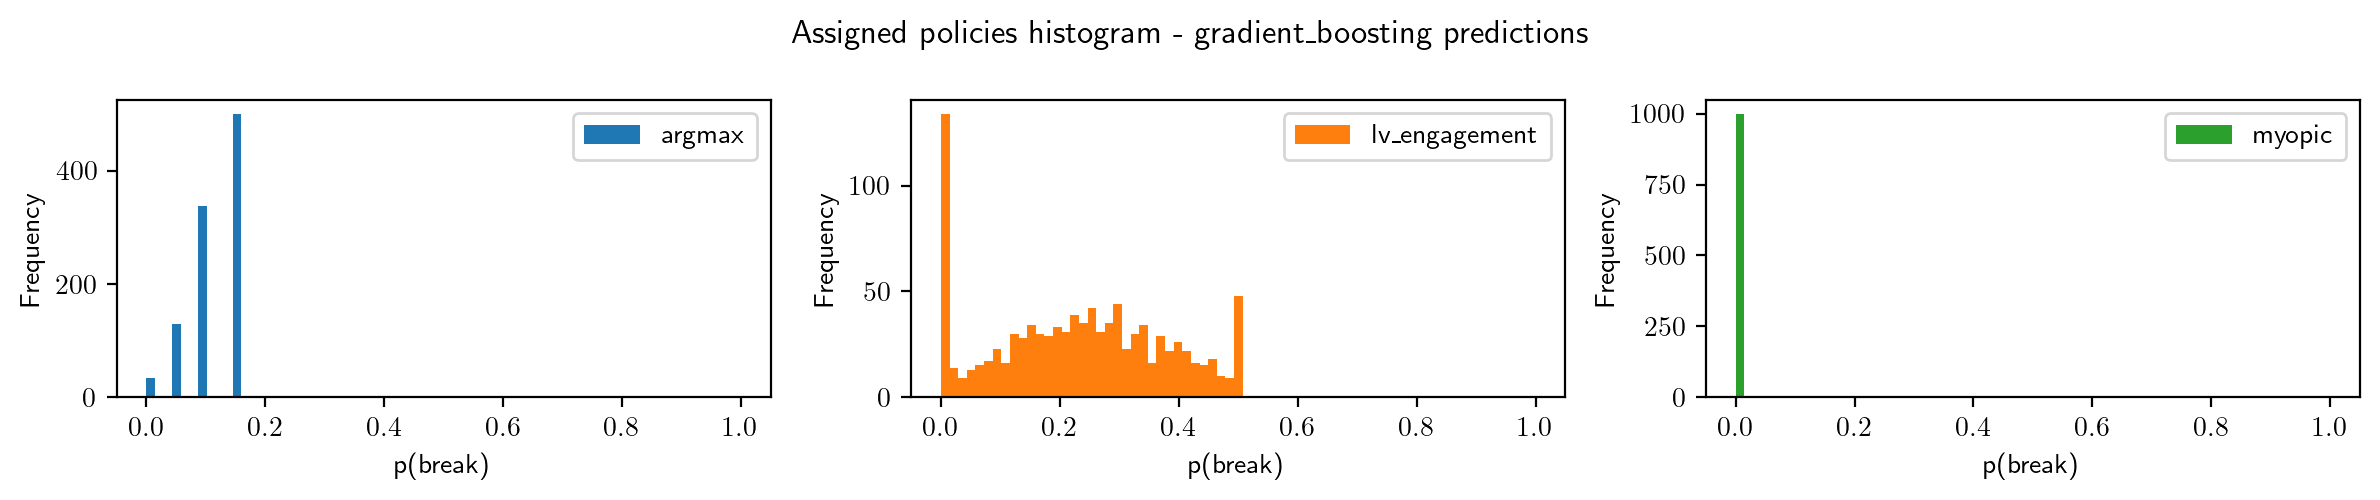

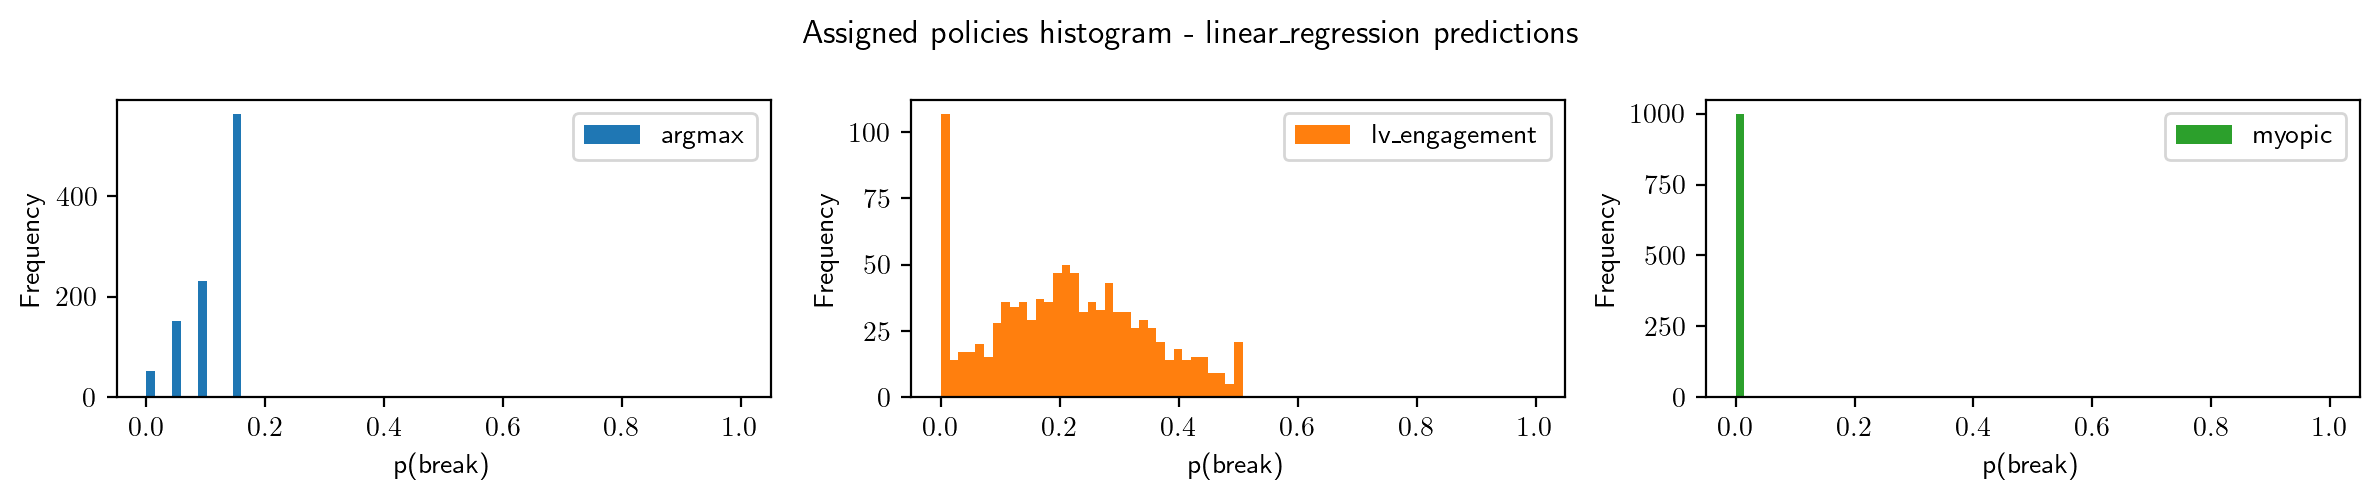

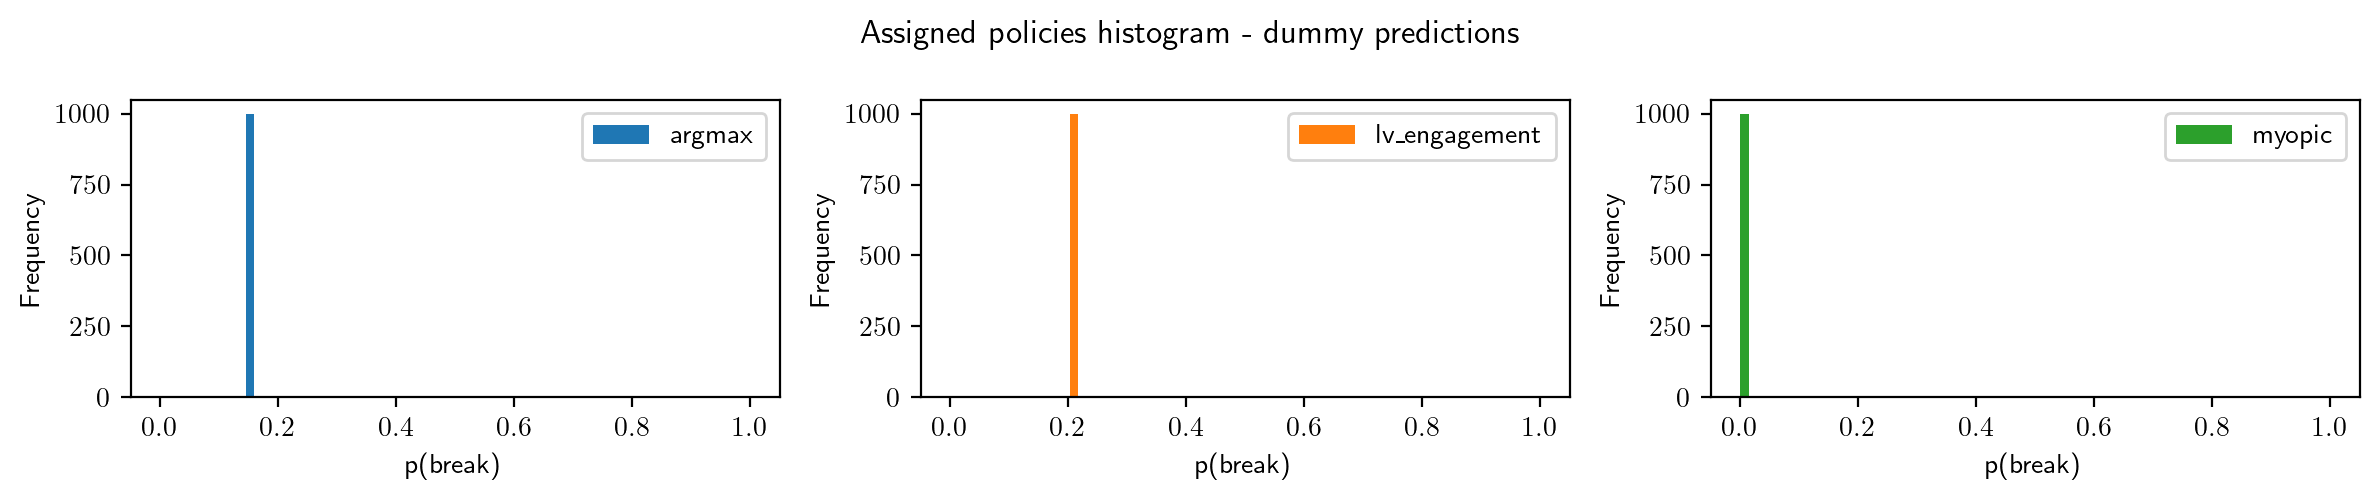

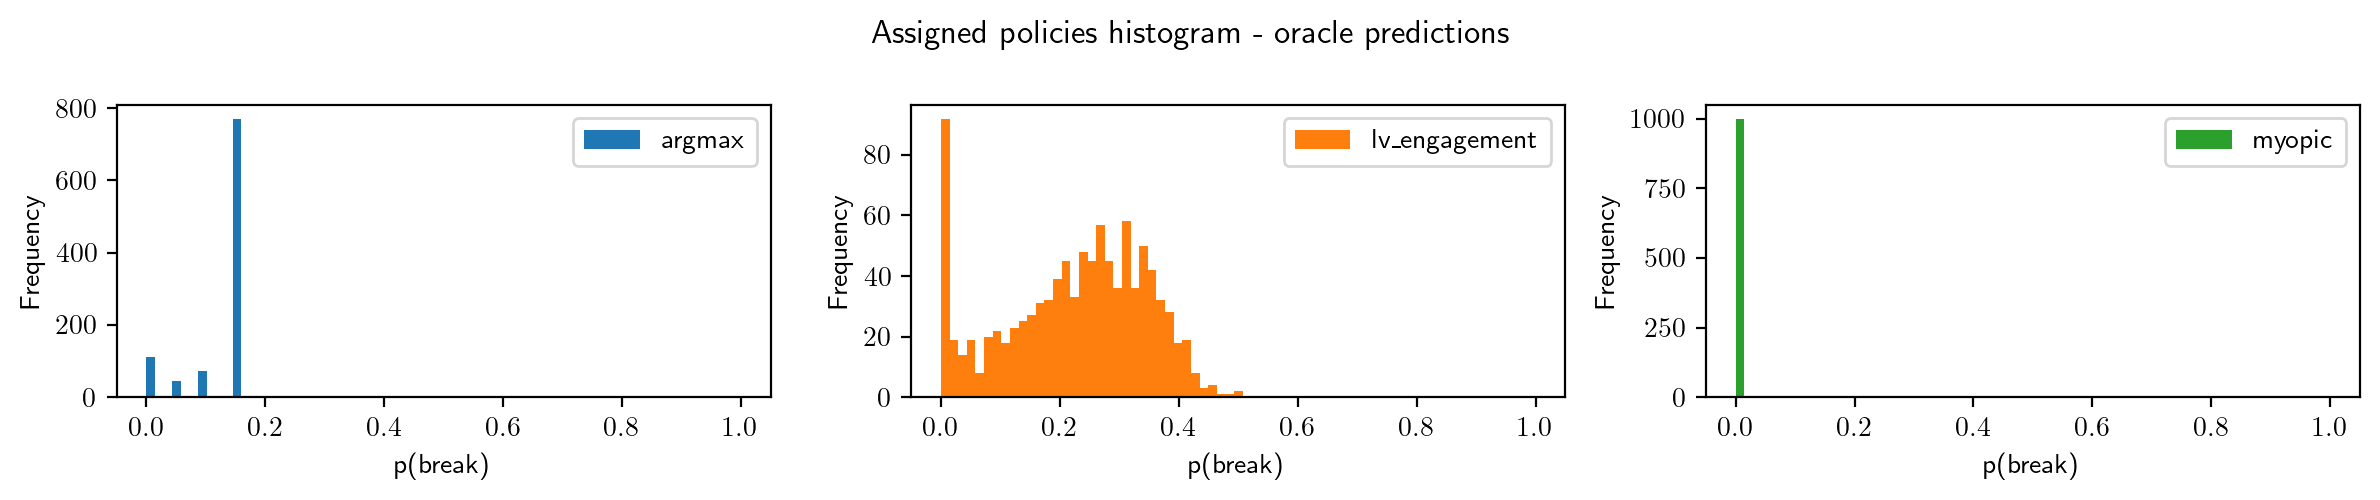

In [26]:
for pred_name in results_df['predictor'].unique():
    fig,axs=plt.subplots(1,len(policies),figsize=(12,2.5))
    (
        results_df
        .query('simulator=="lv_equilibrium" and kappa==0.0 and predictor==@pred_name')
        .pivot(index='user_ind',columns='policy',values='p_fb')
        .plot.hist(
            bins=np.linspace(0,1,70),
            title=f'{pred_name}',
            subplots=True,
            ax=axs,
        )
    )
    [ax.set_xlabel('p(break)') for ax in axs]
    fig.tight_layout()
    fig.suptitle(f'Assigned policies histogram - {pred_name} predictions')
    fig.patch.set_facecolor('white')

### Overall performance

Comparing overall performance:

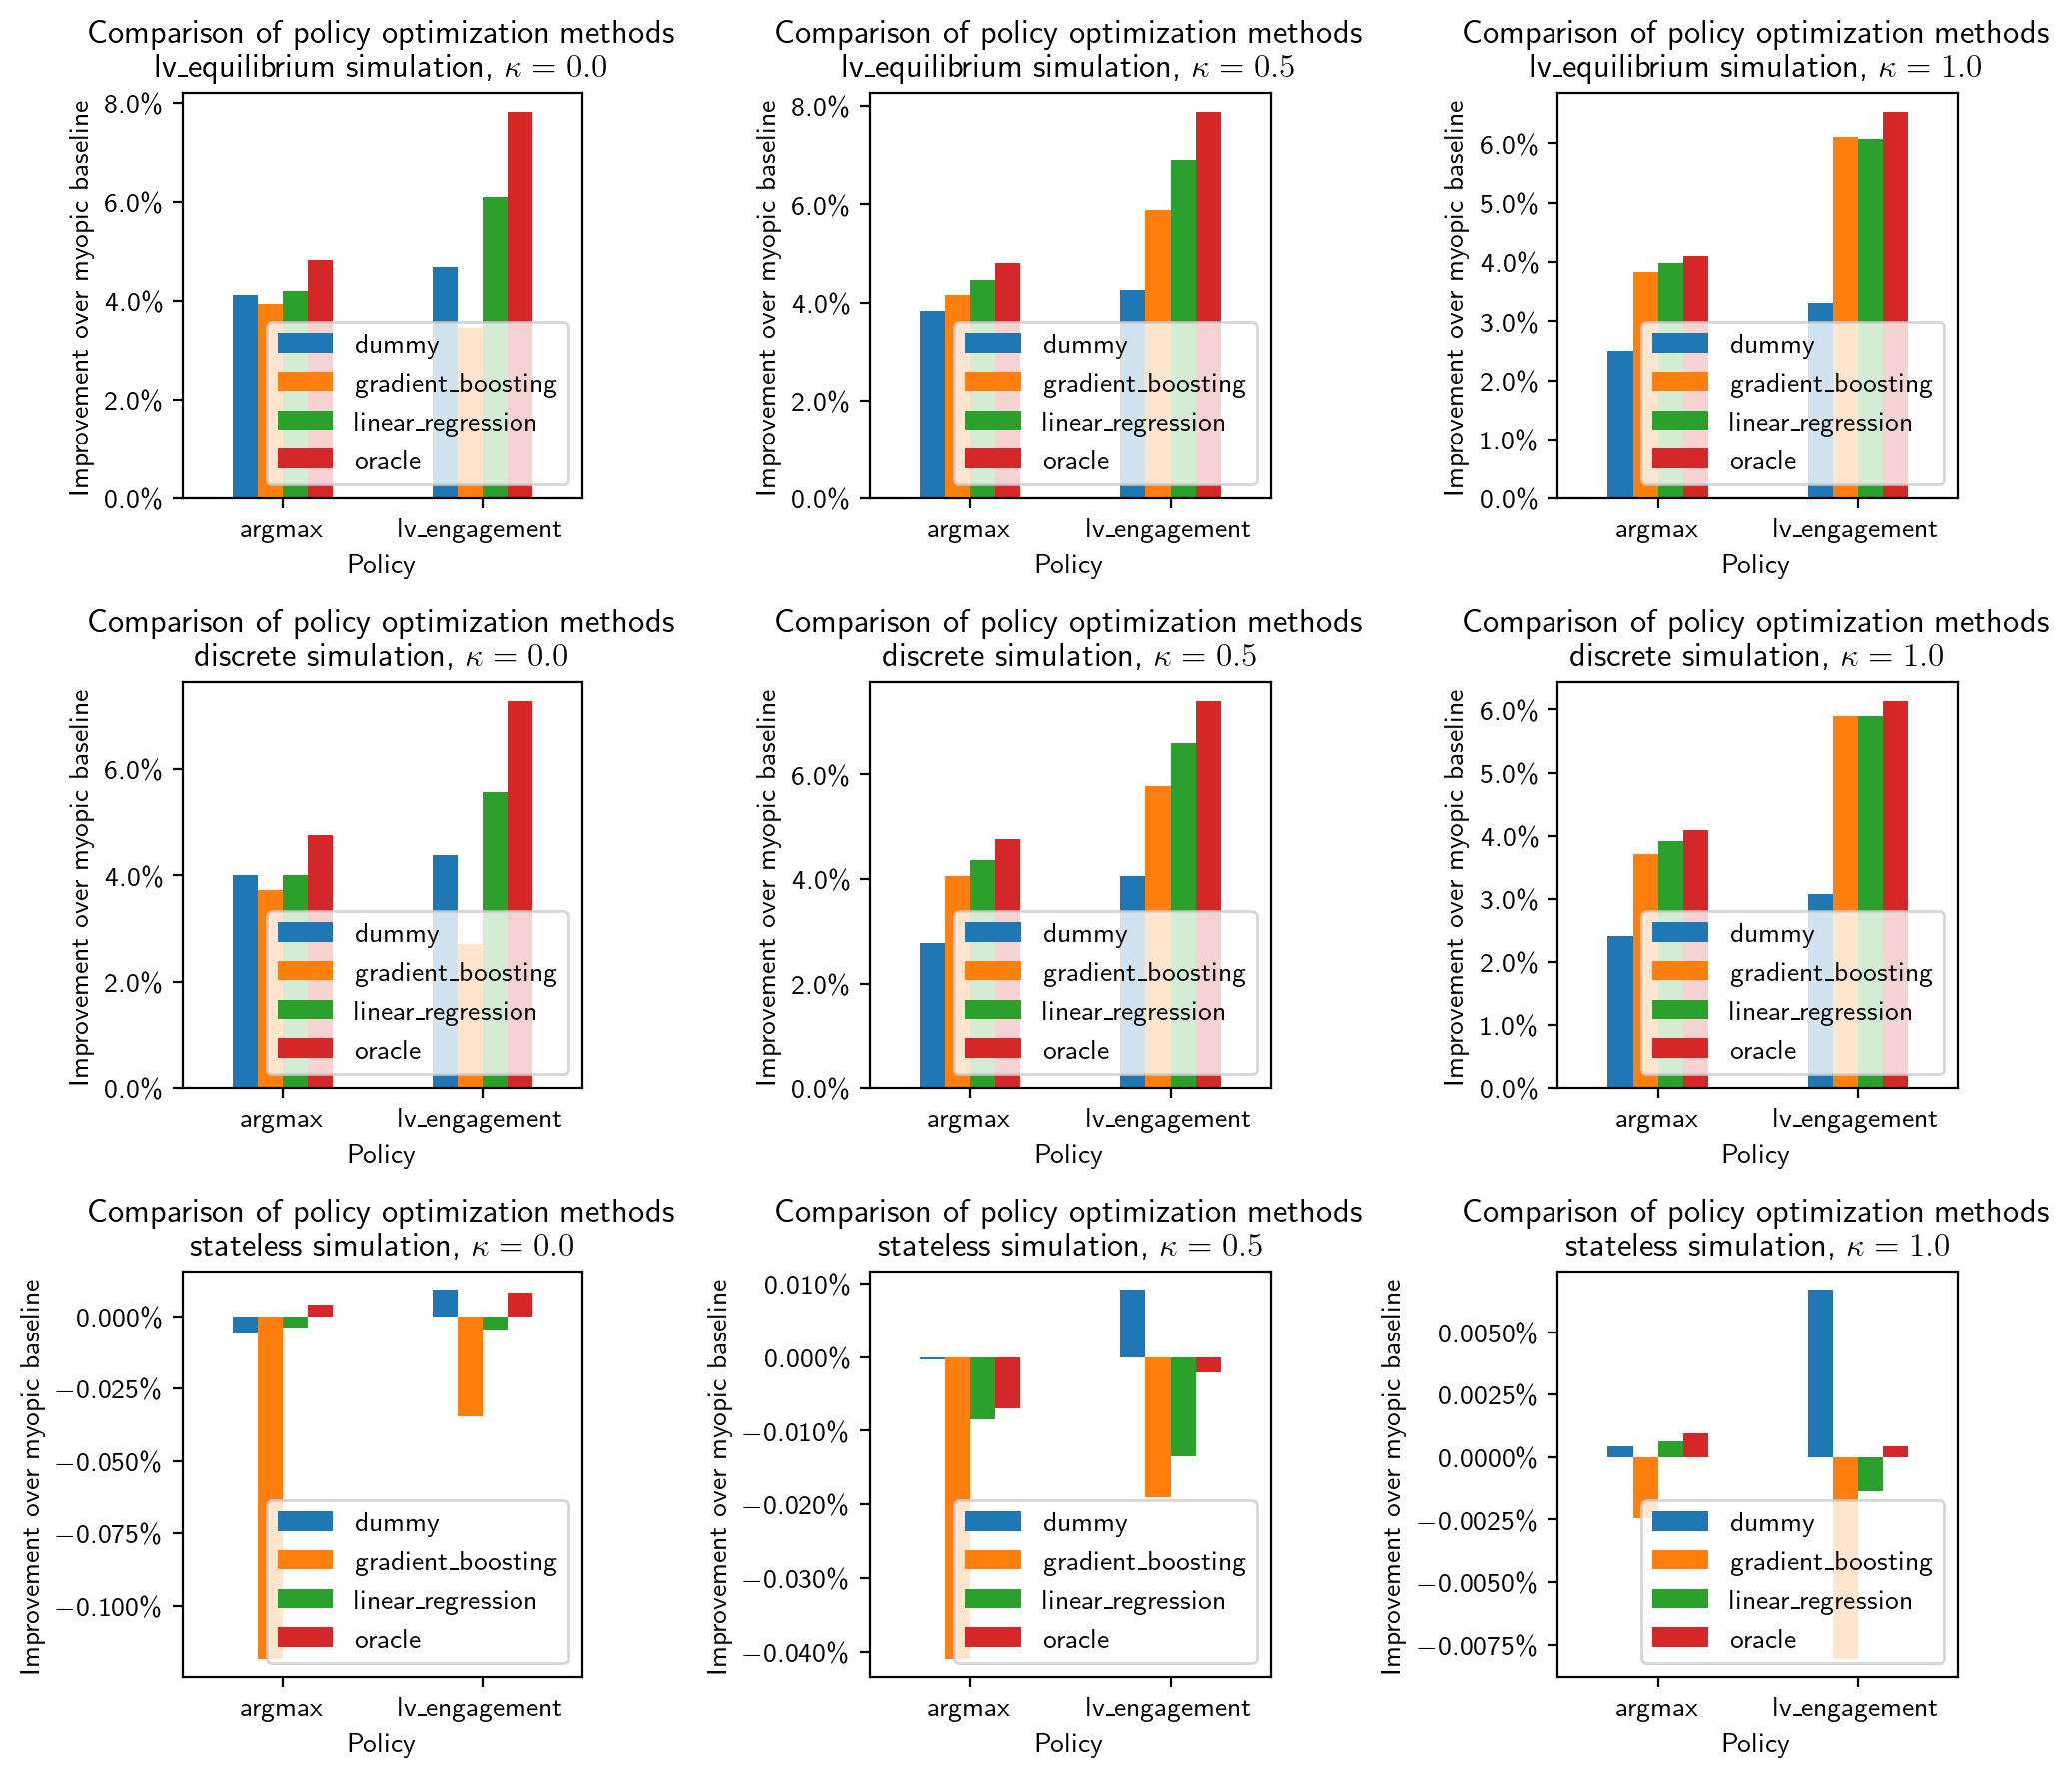

In [27]:
import math

n_rows = math.ceil(len(simulators)/3)
fig,axs=plt.subplots(n_rows,3,figsize=(10,3*n_rows))

for (selected_simulator,selected_kappa),ax in zip(simulators,axs.ravel()):
    (
        results_df
        .query('simulator==@selected_simulator and kappa==@selected_kappa')
        .groupby(['policy','predictor'])
        ['rate']
        .mean()
        .unstack()
        .pipe(lambda df: df/df.loc['myopic']-1)
        .pipe(lambda df: df*100)
        .drop('myopic')
        .plot.bar(ax=ax, rot=0)
    )
    ax.set(
        xlabel='Policy',
        ylabel=f'Improvement over myopic baseline',
        title=f'Comparison of policy optimization methods\n{selected_simulator} simulation, $\kappa={selected_kappa}$'
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.legend(
        loc='lower right',
    )    

fig.tight_layout(w_pad=4)
fig.patch.set_facecolor('white')

### Gain as a function of avg_rating 

In [28]:
selected_simulator = 'discrete'
selected_kappa = 0.0
(
    results_df
    .dropna(subset='avg_rating')
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .query('predictor=="linear_regression"')
    .assign(rating_group=lambda df: df['avg_rating'].map(lambda r, k=2: round(r*k)/k))
    .groupby(['rating_group','policy'])
    ['p_fb']
    .agg(['mean','count'])
    .unstack()
)

mean                       count                     
policy          argmax lv_engagement myopic argmax lv_engagement myopic
rating_group                                                           
0.0           0.000000      0.000000    0.0    2.0           2.0    2.0
2.0                NaN      0.000000    NaN    NaN           1.0    NaN
2.5           0.020000      0.000000    0.0    5.0           4.0    5.0
3.0           0.039394      0.025830    0.0   33.0          33.0   34.0
3.5           0.075854      0.082803    0.0  205.0         205.0  209.0
4.0           0.120192      0.205690    0.0  468.0         471.0  466.0
4.5           0.140545      0.332358    0.0  275.0         273.0  273.0
5.0           0.141667      0.405807    0.0   12.0          11.0   11.0

Text(0.5, 0.98, 'Comparing Selected Policy, Engagement Rate\nlv_equilibrium simulation with $\\kappa=1.0$, linear_regression predictor')

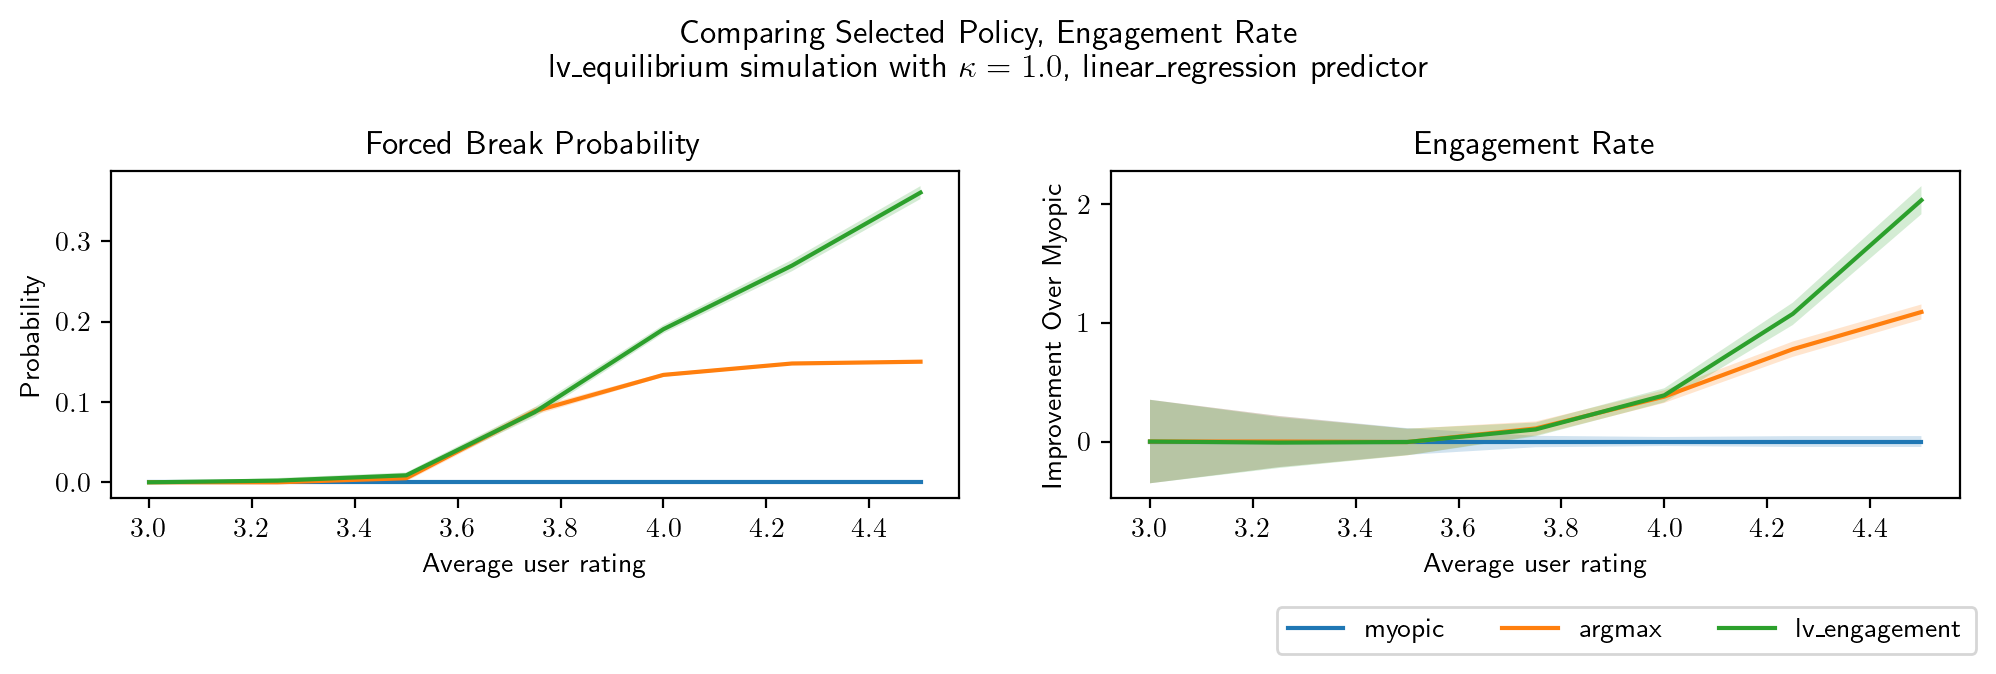

In [29]:
fig,axs = create_fig(1,2)

policy_order = ['myopic','argmax','lv_engagement']

selected_predictor = 'linear_regression'
# selected_predictor = 'gradient_boosting'
# selected_simulator = 'discrete'
# selected_predictor = 'oracle'
selected_simulator = 'lv_equilibrium'
selected_kappa = 1.0

def plot_comparison(df, policy, ax, ci_type, **kwargs):
    m1 = df[policy]['mean']
    n1 = df[policy]['count']
    s1 = df[policy]['std']
    if ci_type=='abs':
        loc = m1
        scale = s1/np.sqrt(n1)
    elif ci_type=='diff':
        m2 = df['myopic']['mean']
        n2 = df['myopic']['count']
        s2 = df['myopic']['std']
        sp = np.sqrt(((n1-1)*s1+(n2-1)*s2)/(n1+n2-2))
        loc = m1-m2
        scale = s1*np.sqrt(1/n1+1/n2)
    else:
        raise ValueError(f'Uknown CI type: {ci_type!r}')
    lines = (
        ax.plot(df.index, loc, label=policy),
        ax.fill_between(
            df.index, 
            *scipy.stats.norm.interval(0.9, loc=loc, scale=scale),
            alpha=0.2,
        ),
    )
    ax.set(**kwargs)
    return lines

def plot_with_ci(df, ci_type, ax, **kwargs):
    lines = (
        df
        .agg([
            'mean',
            'std',
            'count',
        ])
        .stack()
        .swaplevel()
        .unstack()
        .unstack()
        .clip(lower=1e-9)
        .pipe(lambda df: [
            plot_comparison(df, policy, ax, ci_type, **kwargs)
            for policy in policy_order
        ])
    )
    ax.set(**kwargs)
    return lines

rating_results_df = (
    results_df
    .dropna(subset='avg_rating')
    .query('predictor==@selected_predictor and simulator==@selected_simulator and kappa==@selected_kappa')
    .assign(
        rating_group=lambda df: df['avg_rating'].map(lambda r, k=4: round(r*k)/k),
    )
    .query('3.0<=rating_group<=4.7')
    .groupby(['rating_group','policy'])
)

ax = axs[0]
lines = (
    rating_results_df
    ['p_fb']
    .pipe(
        plot_with_ci,
        ci_type='abs',
        ax=ax,
        title='Forced Break Probability',
        ylabel='Probability',
    )
)

ax = axs[1]
(
    rating_results_df
    ['rate']
    .pipe(
        plot_with_ci,
        ci_type='diff',
        ax=ax,
        title='Engagement Rate',
        ylabel='Improvement Over Myopic',
    )
)

for i, ax in enumerate(axs):
    ax.set_xlabel('Average user rating')
    ax.legend().remove()

fig.legend(
    [l[0][0] for l in lines],
    policy_order,
    loc='lower right',
    bbox_to_anchor=(1,-0.1),
    ncol=len(policy_order),
    bbox_transform=fig.transFigure,
)

fig.patch.set_facecolor('white')
fig.tight_layout()
fig.suptitle(
    (
        'Comparing Selected Policy, Engagement Rate'
        f'\n{selected_simulator} simulation with $\kappa={selected_kappa}$, {selected_predictor} predictor'
    ),
)

### Single-user schematic decision diagram

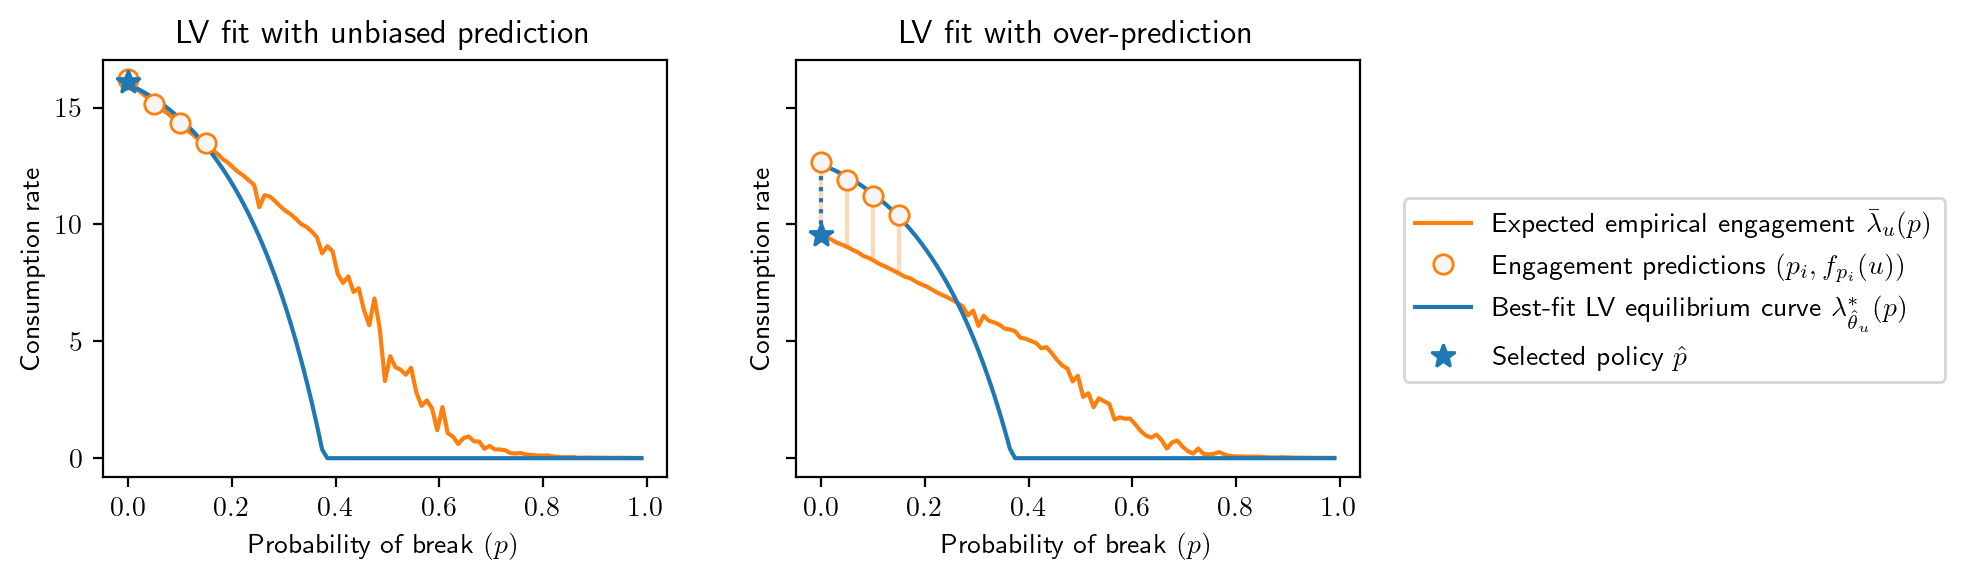

In [30]:
def plot_decision_diagram(user, simulator_name, kappa, predictor_name, ax, short_labels=False):
    p_vec = np.linspace(0,1,100)[:-1]
    true_c = 'tab:orange'
    fit_c = 'tab:olive'
    est_c = 'tab:blue'
    l = 1-int(short_labels)
    
    # Plot equilibrium curve
    simulator = simulators[(simulator_name, kappa)]
    sim_eval = np.vectorize(
        lambda p_fb: np.mean([
            simulator.evaluate_for_user(p_fb=p_fb, user=user)['rate']
            for k in range(10)
        ])
    )
    empirical_rates_raw = sim_eval(p_vec)
    # from scipy.signal import savgol_filter
    import scipy.interpolate
    p_vec_highres = np.linspace(p_vec.min(), p_vec.max(), 200)
    empirical_rates_smooth = scipy.interpolate.pchip_interpolate(
        xi=p_vec,
        yi=empirical_rates_raw,
        x=p_vec_highres,
    )
    # empirical_rates_smooth = savgol_filter(empirical_rates_raw, 11, 3)
    true_empricial_rate = scipy.interpolate.interp1d(
        x=p_vec_highres,
        y=empirical_rates_smooth,
    )

    ax.plot(
        p_vec,
        true_empricial_rate(p_vec),
        color=true_c,
        label='Expected empirical engagement '*l + r'$\bar{\lambda}_u(p)$',
    )
        
    f = {
        p: lambda u, p=p: predictor_funcs[(predictor_name, (simulator_name, kappa), p)]([u])[0]
        for p in treatments
    }
    u = X[user.iuid]
    data_points = {
        p: f[p](u)
        for p in f
    }
    
    # Plot predictions
    ax.plot(
        *np.array(list(data_points.items())).T,
        'o',
        color='whitesmoke',
        markersize=7,
        markeredgecolor=true_c,
        label='Engagement predictions '*l + r'$\left(p_i, f_{p_i}(u)\right)$',
        zorder=100,
    )
    for p,fp in data_points.items():
        ax.plot(
            [p,p],
            [true_empricial_rate(p), fp],
            color=true_c,
            alpha=0.3,
            zorder=-20,
        )
        
    # Estimated LV curve
    est_params = (
        lvml.LotkaVolterraOptimalForcedBreaksPolicy
        .lv_params_from_predictions(data_points)
    )
    ax.plot(
        p_vec,
        lv_eq_f(*est_params,p_fb=p_vec),
        color=est_c,
        label='Best-fit LV equilibrium curve '*l + r'$\lambda^*_{\hat{\theta}_u}(p)$'
    )
    for p,fp in data_points.items():
        ax.plot(
            [p,p],
            [data_points[p], lv_eq_f(*est_params,p_fb=p)],
            color=est_c,
            linestyle=':',
            zorder=-10,
        )

    # Optimal points
    p_fb_opt_est = p_opt_f(est_params[0])
    ax.plot(
        [p_fb_opt_est]*2,
        [
            lv_eq_f(*est_params,p_fb=p_fb_opt_est),
            true_empricial_rate(p_fb_opt_est),
        ],
        ':',
        color=est_c,
    )
    ax.plot(
        p_fb_opt_est,
        true_empricial_rate(p_fb_opt_est),
        '*',
        color=est_c,
        markersize=9,
        label='Selected policy '*l + r'$\hat{p}$',
        zorder=200,
    )

    p_fb_true_opt = p_vec_highres[np.argmax(empirical_rates_smooth)]
    # ax.plot(
    #     p_fb_true_opt,
    #     true_empricial_rate(p_fb_true_opt),
    #     '*',
    #     color=true_c,
    #     markersize=9,
    #     label=r'$p^*$'
    # )

selected_users = (
    pd.Series({i: eq['rate'] for i, eq in enumerate(policy_equilibrium[('lv_engagement','linear_regression',('stateless',0.0))])})
    .sort_values()
    .iloc[[500,3,998]]
    .pipe(lambda s: list(s.index))
)
# selected_users = [
#     (317, 'Stateless model fit from noisy predictions'),
#     (920, 'Stateless model fit from biased predictions'),
# ]

for sim_name in ['stateless']:
    fig,axs=create_fig(1,2,sharey=True,tight_layout=dict(w_pad=3, rect=(0,0,0.7,1)))
    # fig,axs=plt.subplots(1,3,figsize=(10,3),sharey=True)
    for user_ind, ax, user_type in zip(
        selected_users,
        axs,
        ['unbiased prediction','over-prediction','under-prediction'],
    ):
        plot_decision_diagram(
            user=users_eval[user_ind],
            simulator_name=sim_name,
            kappa=0.0,
            predictor_name='linear_regression',
            ax=ax,
        )
        # ax.legend()
        ax.set(
            title=f'LV fit with {user_type}',
            xlabel=r'Probability of break $\left(p\right)$',
            ylabel='Consumption rate',
        )
        
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc='center left',
        bbox_to_anchor=(0.7, 0.5),
        # bbox_transform=fig.transFigure,
        # borderaxespad=-10,
    )
    fig.download(f'{sim_name}_model_curve_fitting_experiment.pdf')

In [31]:
# Find users with low/typical/high engagement

(
    pd.Series({i: eq['rate'] for i, eq in enumerate(policy_equilibrium[('lv_engagement','linear_regression',('stateless',0.0))])})
    .sort_values()
    .iloc[[500,1,999]]
    .pipe(lambda s: list(s.index))
)

[388, 346, 920]

### Stateless model - Policy decisions

In [32]:
(
    results_df
    .query('simulator=="stateless"')
    .assign(has_breaks=lambda df: df['p_fb']>0)
    .groupby(['kappa','policy','predictor'])
    ['has_breaks']
    .sum()
    .unstack()
    .unstack()
    [['oracle','linear_regression']]
)

predictor oracle                      linear_regression                     
policy    argmax lv_engagement myopic            argmax lv_engagement myopic
kappa                                                                       
0.0            0             0      0                 0             0      0
0.5            0             0      0                 0             0      0
1.0            0             0      0                 0             0      0

## Adaptive policies

<AxesSubplot:ylabel='Frequency'>

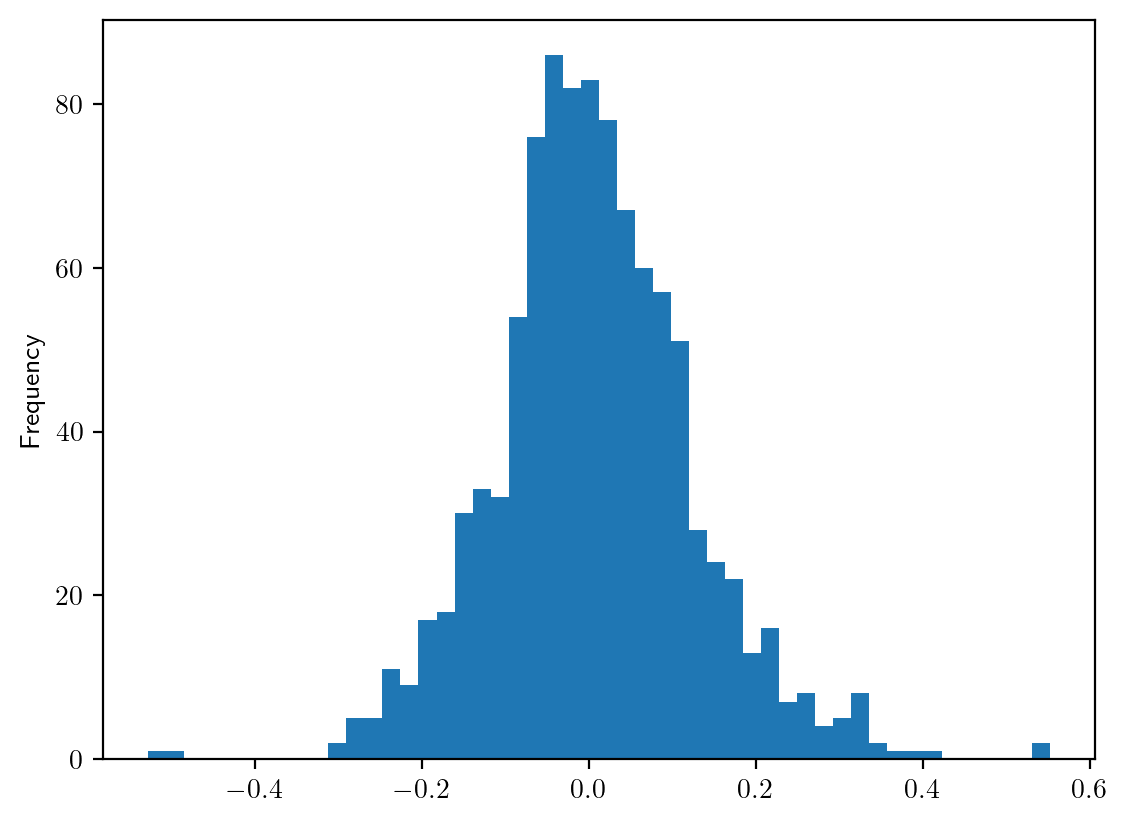

In [33]:
def average_true_rating_user(user, softmax_t, kappa):
    est_ratings = user.predicted_ratings()
    true_ratings = user.true_ratings(kappa)
    return (true_ratings*softmax(est_ratings/softmax_t)).sum()

X_eval_true_ratings = X_eval.copy()
X_eval_true_ratings[:,-1] = [
    average_true_rating_user(u, softmax_t=get_param('softmax_t'), kappa=0.5)
    for u in users_eval
]
pd.Series(X_eval[:,-1]-X_eval_true_ratings[:,-1]).plot.hist(bins=50)

In [34]:
selected_kappa = 0.0
selected_simulator = 'discrete'
selected_predictor = 'linear_regression'

chosen_p_true_ratings = (
    policy_optimizers
    [('lv_engagement',selected_predictor,(selected_simulator, selected_kappa))]
    .p_forced_break(X_eval_true_ratings)
)
true_ratings_results_df = pd.DataFrame([
    {
        'simulator': selected_simulator,
        'kappa': selected_kappa,
        'predictor': selected_predictor,
        'policy': 'lv_engagement_true_ratings',
        'user_ind': i,
        'p_fb': chosen_p_true_ratings[i],
        **simulators[(selected_simulator,selected_kappa)].evaluate_for_user(
            p_fb=chosen_p_true_ratings[i],
            user=users_eval[i],
        )
    }
    for i in range(len(users_eval))
])
true_ratings_results_df.head()

,simulator,kappa,predictor,policy,user_ind,p_fb,rate,avg_rating,survival_pct
0,discrete,0.0,linear_regression,lv_engagement_true_ratings,0,0.193100,13.31,4.063984,0.999886
1,discrete,0.0,linear_regression,lv_engagement_true_ratings,1,0.206835,13.00,3.967842,0.999584
2,discrete,0.0,linear_regression,lv_engagement_true_ratings,2,0.223299,12.86,4.040566,0.999621
3,discrete,0.0,linear_regression,lv_engagement_true_ratings,3,0.116413,10.92,3.586515,0.999983
4,discrete,0.0,linear_regression,lv_engagement_true_ratings,4,0.273378,13.56,4.131146,0.999785


In [35]:
# from lvml.core.simulation import AdaptiveRatingsPolicyParams
from tqdm.auto import tqdm

selected_kappa = param(0.0, 'adaptive_policy_selected_kappa')
selected_simulator = 'discrete'
selected_predictor = 'linear_regression'

selected_policy_optimizer = policy_optimizers[('lv_engagement',selected_predictor,(selected_simulator,selected_kappa))]
optimize_policy = lambda feature_vec: (
    selected_policy_optimizer
    .p_forced_break(np.expand_dims(feature_vec,axis=0))[0]
)
    
adaptive_results = {}

sampling_rate_vec = np.geomspace(5e-3,1.0,15)
T0_vec = [
    param(5, 'adaptive_t0_medium'),
    param(0.5, 'adaptive_t0_small'),
    param(50, 'adaptive_t0_large'),
]
for r in tqdm(sampling_rate_vec):
    adaptive_results[r]={}
    for T0 in T0_vec:
        adaptive_results[r][T0] = []
        for i in range(len(X_eval)):
            def adaptive_policy_callback(events, agg):
                h = agg.ratings_histogram
                rating_estimation = (h/(h.sum()+1e-6))@np.arange(1,6)
                orig_feature_vec = X_eval[i]
                feature_vec = np.hstack([orig_feature_vec[:-1], [rating_estimation]])
                return optimize_policy(feature_vec)

            adaptive_sim = DiscreteEmpiricalRateSimulator(
                behavioral_model=lv_base,
                kappa=selected_kappa,
                random_state=RANDOM_STATE,
                simulator_params=dict(
                    batch_size=get_param('discrete_simulation_batch_size'),
                    record_events=False,
                    adaptive_policy_params=lvml.AdaptiveRatingsPolicyParams(
                        callback_time=T0,
                        callback_f=adaptive_policy_callback,
                        rating_sampling_rate=r,
                    )
                ),
                # return_result=True,
            )

            res = adaptive_sim.evaluate_for_user(
                p_fb=optimize_policy(X_eval[i]),
                user=users_eval[i],
            )

            adaptive_results[r][T0].append(res)
    
adaptive_results_df = pd.DataFrame([
    {
        'simulator': selected_simulator,
        'kappa': selected_kappa,
        'predictor': selected_predictor,
        'policy': 'lv_engagement_adaptive',
        'user_ind': i,
        'p_fb': None,
        **adaptive_results[r][T0][i],
        'sampling_rate':r,
        'T0':T0,
    }
    for r in sampling_rate_vec
    for T0 in T0_vec
    for i in range(len(users_eval))
])

adaptive_results_df

  0%|          | 0/15 [00:00<?, ?it/s]

,simulator,kappa,predictor,policy,user_ind,p_fb,rate,avg_rating,survival_pct,sampling_rate,T0
0,discrete,0.0,linear_regression,lv_engagement_adaptive,0,None,11.30,4.050860,0.999604,0.005,5.0
1,discrete,0.0,linear_regression,lv_engagement_adaptive,1,None,12.40,3.957751,0.999396,0.005,5.0
2,discrete,0.0,linear_regression,lv_engagement_adaptive,2,None,12.62,4.066330,0.999604,0.005,5.0
3,discrete,0.0,linear_regression,lv_engagement_adaptive,3,None,10.90,3.608278,0.999558,0.005,5.0
4,discrete,0.0,linear_regression,lv_engagement_adaptive,4,None,12.82,4.138656,0.999625,0.005,5.0
...,...,...,...,...,...,...,...,...,...,...,...
44995,discrete,0.0,linear_regression,lv_engagement_adaptive,995,None,15.03,4.307011,0.999902,1.000,50.0
44996,discrete,0.0,linear_regression,lv_engagement_adaptive,996,None,12.96,4.272651,0.999988,1.000,50.0
44997,discrete,0.0,linear_regression,lv_engagement_adaptive,997,None,10.96,3.643783,0.999635,1.000,50.0
44998,discrete,0.0,linear_regression,lv_engagement_adaptive,998,None,14.28,4.243104,0.999284,1.000,50.0


In [36]:
adaptive_policy_performance = (
    pd.concat([
        results_df.assign(sampling_rate=1.0, T0=0),
        true_ratings_results_df.assign(sampling_rate=1.0, T0=0),
        adaptive_results_df,
    ])
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .pivot('user_ind',['predictor','policy','sampling_rate', 'T0'],'rate')
    .mean()
    .sort_index()
    .pipe(lambda s: s/s.loc[(selected_predictor,'myopic',1.0,0)])
    # .loc[[selected_predictor]]
    # .loc[(selected_predictor,slice(None),1.0)]
    .pipe(lambda s: pd.concat([
        s.xs(selected_predictor,drop_level=False),
        s.xs(('oracle','lv_engagement'),drop_level=False),
    ]))
)
adaptive_policy_performance

predictor          policy                      sampling_rate  T0  
linear_regression  argmax                      1.000000       0.0     1.040042
                   lv_engagement               1.000000       0.0     1.055703
                   lv_engagement_adaptive      0.005000       0.5     0.992631
                                                              5.0     0.979616
                                                              50.0    1.055134
                                               0.007300       0.5     0.967430
                                                              5.0     0.989524
                                                              50.0    1.055604
                                               0.010658       0.5     0.962878
                                                              5.0     1.010326
                                                              50.0    1.058307
                                               0.015561       0.

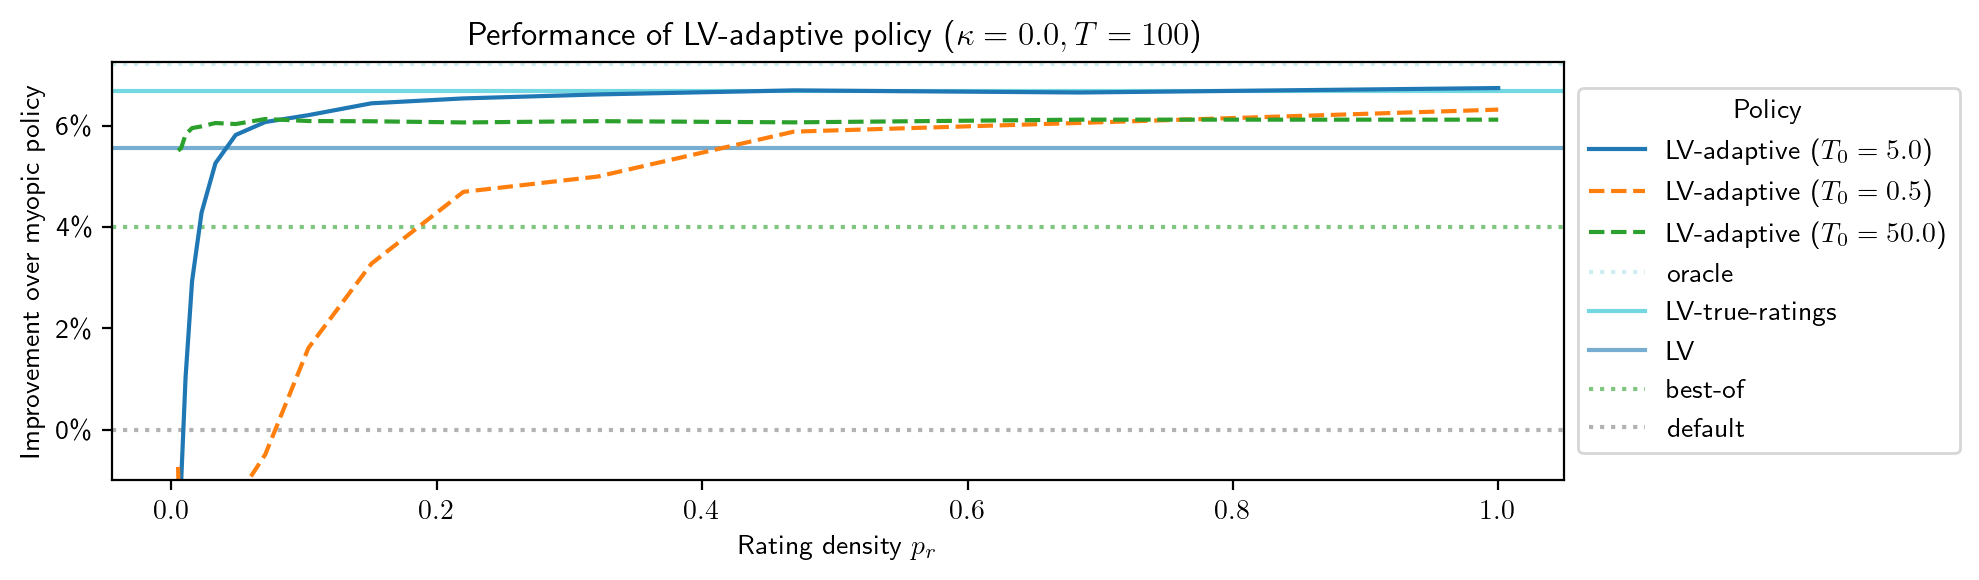

In [37]:
policy_color_config={
    (selected_predictor,'myopic'): ('default', 'tab:gray', ''),
    (selected_predictor,'argmax'): ('best-of', 'tab:green', ''),
    (selected_predictor,'lv_engagement'): ('LV', 'tab:blue', ''),
    (selected_predictor,'lv_engagement_adaptive'): ('LV-adaptive', 'deepskyblue', ''),
    (selected_predictor,'lv_engagement_true_ratings'): ('LV-true-ratings', 'tab:cyan', ''),
    ('oracle','lv_engagement'): ('oracle', 'powderblue', ''),
}

fig,ax=create_fig(figsize=(10,3))
(
    adaptive_policy_performance
    .loc[(selected_predictor,'lv_engagement_adaptive')]
    .unstack()
    [T0_vec]
    .apply(lambda s: s.plot.line(
        ax=ax,
        label=f'LV-adaptive ($T_0={s.name}$)',
        # alpha=1 if s.name==5 else 0.9,
        linestyle='-' if s.name==T0_vec[0] else '--',
    ))
    # .plot.line(
    #     ax=ax,
    #     label='LV-adaptive',
    #     color=bar_plot_config[(selected_predictor,'lv_engagement_adaptive')][1],
    # )
)

(
    adaptive_policy_performance
    .droplevel(2)
    .droplevel(2)
    .loc[list(policy_color_config)[::-1]]
    .drop((selected_predictor,'lv_engagement_adaptive'))
    .rename('rate')
    .reset_index()
    .apply(lambda row: ax.axhline(
        row['rate'],
        label=policy_color_config[(row['predictor'],row['policy'])][0],
        color=policy_color_config[(row['predictor'],row['policy'])][1],
        zorder=-5,
        alpha=0.6,
        linestyle='-' if ('lv' in row['policy'] and row['predictor']==selected_predictor) else ':',
    ), axis=1)
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Policy')
ax.set(
    # xscale='log',
    xlabel='Rating density $p_r$',
    ylabel='Improvement over myopic policy',
    title=f'Performance of LV-adaptive policy ($\\kappa={selected_kappa}, T={get_param("simulation_length")}$)',
    ylim=(0.99,None)
)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round((x-1)*100)}\%'))
# ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100)}\%'))
fig.download('adaptive_policy_experiment.pdf')

## Sensitivity analysis

In [38]:
sensitivity_simulators = [sim for sim in simulators if sim[0]=='lv_equilibrium']
sensitivity_treatments = param(np.linspace(0,0.4,6), 'sensitivity_analysis_treatments')
sensitivity_treatment_datasets = treatments_split(sensitivity_treatments)

Array shapes for each treatment group:
0.0: (3528, 10)
0.08: (302, 10)
0.16: (303, 10)
0.24: (302, 10)
0.32: (303, 10)
0.4: (302, 10)
Group weights: [0.7  0.06 0.06 0.06 0.06 0.06]


### Build training sets

In [39]:
sensitivity_predictor_funcs = learn_engagement_predictors(sensitivity_treatment_datasets)

Building training sets... Done (0:00:33.778897)
Training supervised predictors... Done (0:00:10.160513)
Fitting KNN oracle predictor... Done (0:00:40.284724)


In [40]:
optimizer_variation_modes = ['two-treatment','cumulative']

with print_progress('Choosing variation policies'):
    sensitivity_optimizers = {
        (policy_name, pred_name, kappa, p1, mode): (
            policy_cls(
                predictors={
                    p: f
                    for (prd, sim, p), f in sensitivity_predictor_funcs.items()
                    if (
                        prd==pred_name 
                        and sim==('lv_equilibrium',kappa)
                        and ((p in [0.0, p1]) if mode=='two-treatment' else (p<=p1))
                    )
                },
            )
        )
        for policy_name, policy_cls in policies.items()
        for pred_name in predictor_names
        for kappa in kappa_values
        for p1 in sensitivity_treatments[1:]
        for mode in optimizer_variation_modes
    }

    sensitivity_chosen_policy = {
        (policy_name, pred_name, kappa, p1, mode): optimizer.p_forced_break(X_eval)
        for (policy_name, pred_name, kappa, p1, mode), optimizer in sensitivity_optimizers.items()
    }

Choosing variation policies... Done (0:00:27.173619)


In [41]:
with print_progress('Calculating engagement for optimizer variation policies'):
    optimizer_variations_policy_equilibrium = {
        (policy_name, pred_name, kappa, p1, mode): (
            simulators[('discrete',kappa)]
            .evaluate_from_users_personalized(p_fb_vec=p_break, users=users_eval)
        )
        for (policy_name, pred_name, kappa, p1, mode), p_break in sensitivity_chosen_policy.items()
    }

Calculating engagement for optimizer variation policies... Done (0:06:57.037313)


### Analyze results 

In [42]:
optimizer_variations_results_df = pd.DataFrame([
    {
        'policy': policy_name,
        'predictor': pred_name,
        'kappa': kappa,
        'p1': p1,
        'mode': mode,
        'user_ind': i,
        'p_fb': sensitivity_chosen_policy[(policy_name, pred_name, kappa, p1, mode)][i],
        **optimizer_variations_policy_equilibrium[(policy_name, pred_name, kappa, p1, mode)][i],
    }
    for policy_name in policies
    for pred_name in predictor_names
    for kappa in kappa_values
    for p1 in sensitivity_treatments[1:]
    for mode in optimizer_variation_modes
    for i in range(len(X_eval))
])
optimizer_variations_results_df

,policy,predictor,kappa,p1,mode,user_ind,p_fb,rate,avg_rating,survival_pct
0,lv_engagement,gradient_boosting,0.0,0.08,two-treatment,0,0.500000,10.22,4.079427,0.998905
1,lv_engagement,gradient_boosting,0.0,0.08,two-treatment,1,0.138961,12.70,3.956919,0.999412
2,lv_engagement,gradient_boosting,0.0,0.08,two-treatment,2,0.500000,9.47,4.070068,0.999428
3,lv_engagement,gradient_boosting,0.0,0.08,two-treatment,3,0.000000,10.89,3.594582,0.999738
4,lv_engagement,gradient_boosting,0.0,0.08,two-treatment,4,0.374508,13.05,4.122794,0.999817
...,...,...,...,...,...,...,...,...,...,...
359995,myopic,oracle,1.0,0.40,cumulative,995,0.000000,13.07,4.300612,0.999745
359996,myopic,oracle,1.0,0.40,cumulative,996,0.000000,13.80,4.538986,0.999879
359997,myopic,oracle,1.0,0.40,cumulative,997,0.000000,9.73,3.533813,0.999061
359998,myopic,oracle,1.0,0.40,cumulative,998,0.000000,12.66,4.153239,0.999820


<AxesSubplot:xlabel='p1'>

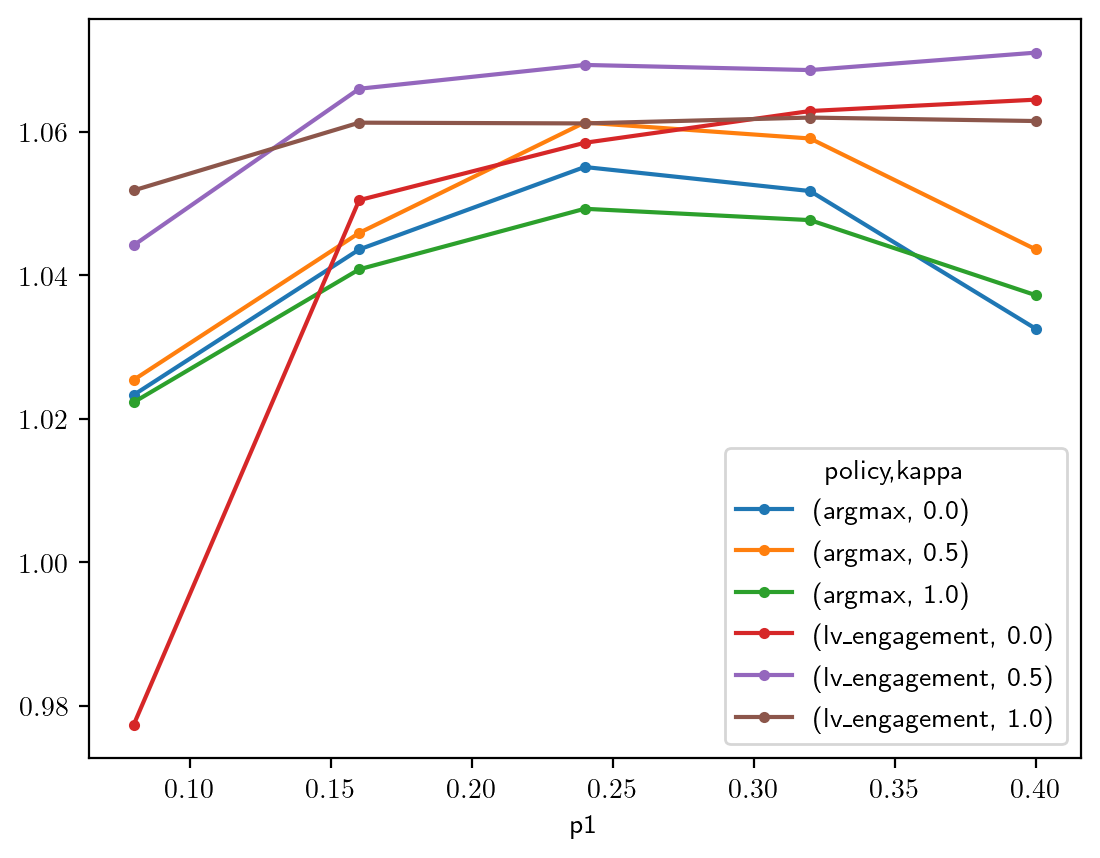

In [43]:
(
    optimizer_variations_results_df
    .pivot(
        ['p1','mode','predictor','kappa','user_ind'],
        'policy',
        'rate',
    )
    .groupby(level=[0,1,2,3])
    .mean()
    .apply(lambda row: row/row['myopic'], axis=1)
    [['argmax','lv_engagement']]
    .loc[(
        slice(None),
        'two-treatment',
        'linear_regression',
        [0.0,0.5,1.0],
    )]
    .droplevel([1,2])
    .unstack()
    .plot.line(marker='.')
    # .xs('linear_regression', level=2)
    # .xs('two-treatment', level=1)
    # .xs((0.0,0.5), level=1)
    # .unstack()
    
)

### Argmax sensitivity

<AxesSubplot:xlabel='p1'>

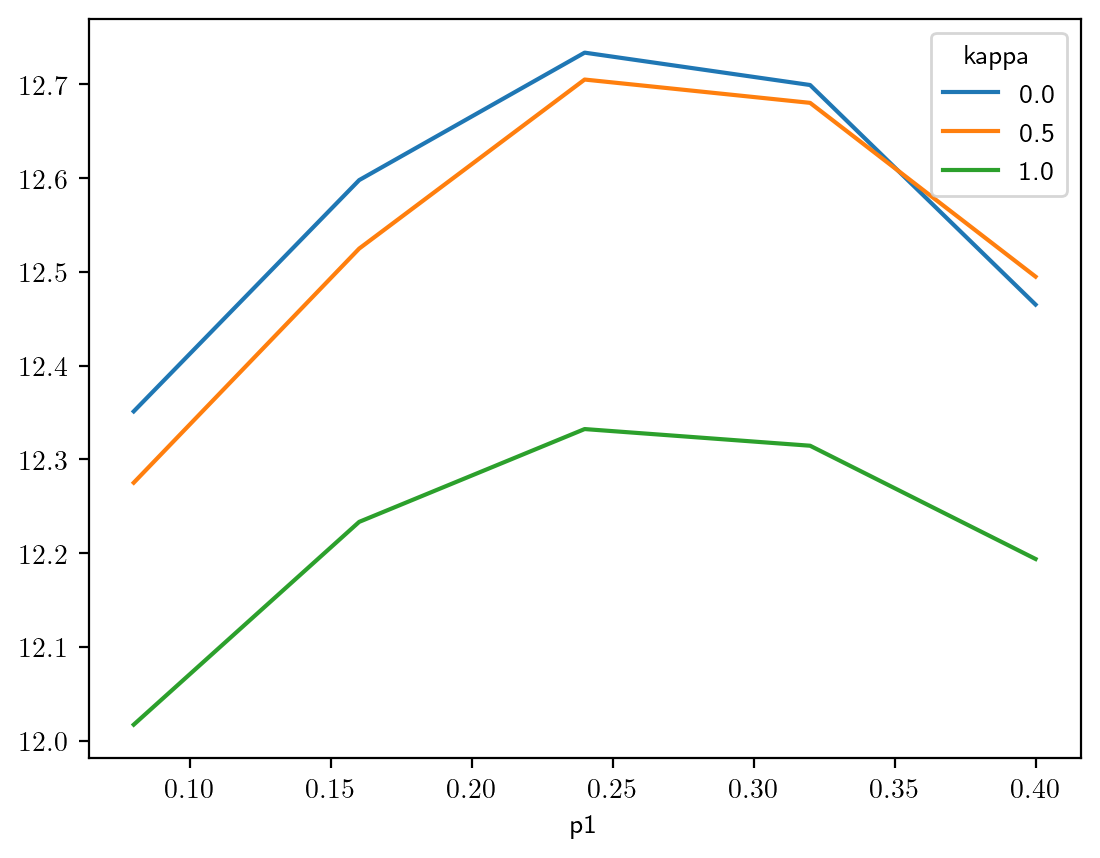

In [44]:
(
    optimizer_variations_results_df
    .groupby(['policy','predictor','p1','kappa','mode'])
    ['rate']
    .mean()
    .loc[
        ('argmax','linear_regression',slice(None),slice(None),'two-treatment')
    ]
    .unstack()
    .plot.line()
    # [0.0]
)

## Safety policy

In [45]:
safety_selected_kappa = 0.5
threshold_vals = np.arange(14,21)
threshold_res = {}

for thresh in threshold_vals:
    print(thresh)
    limit_params = lvml.RateLimitParams(
        lookback_n=10,
        rate_upper_bound=thresh,
        cooldown_period=0.5,
    )

    safety_sim = DiscreteEmpiricalRateSimulator(
        behavioral_model=lv_base,
        kappa=safety_selected_kappa,
        random_state=RANDOM_STATE,
        simulator_params=dict(
            batch_size=get_param('discrete_simulation_batch_size'),
            record_events=True,
            rate_limit_params=limit_params,
        ),
    )

    threshold_res[thresh] = safety_sim.empirical_rate_from_users_vec(0, users_eval)
    
myopic_mean = (
    results_df
    .query('simulator=="discrete" and policy=="myopic" and predictor=="linear_regression" and kappa==@safety_selected_kappa')
    ['rate']
    .mean()
)

14
15
16
17
18
19
20


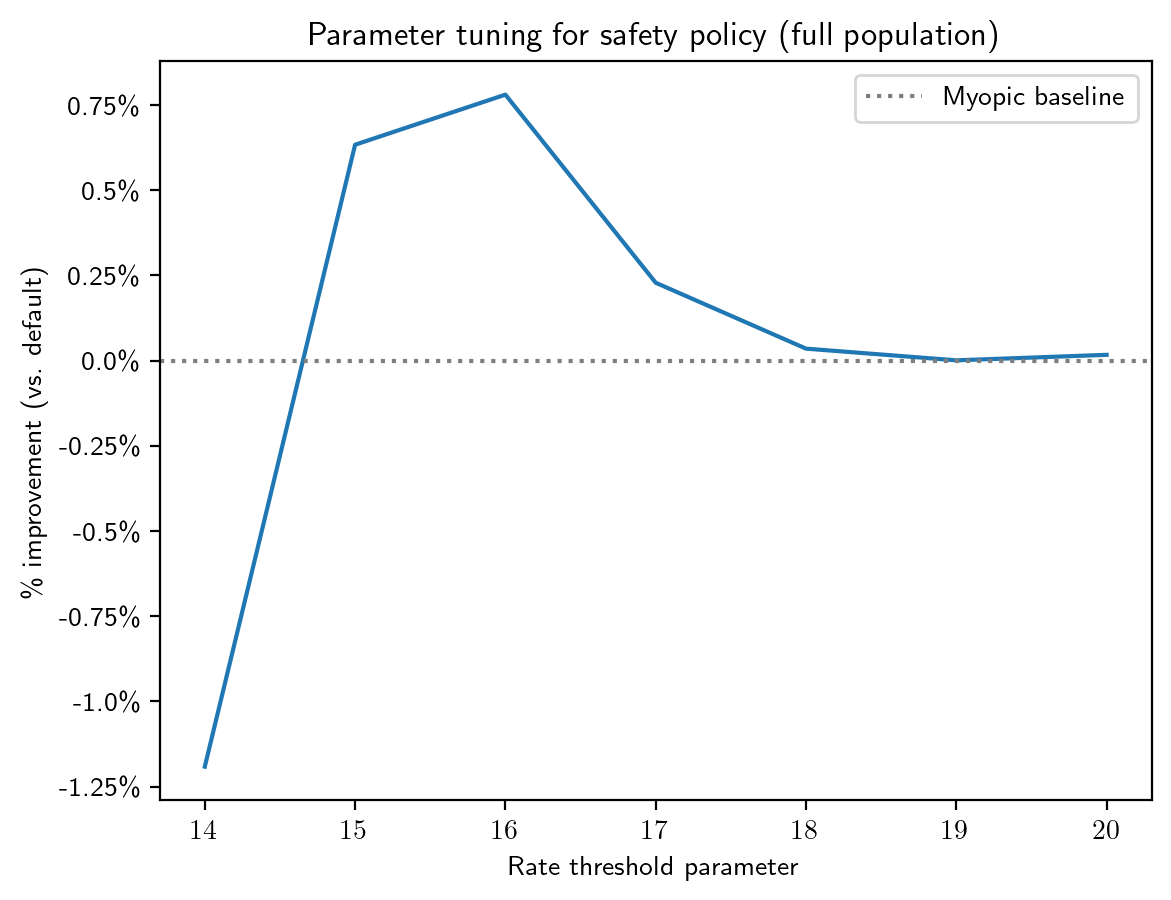

In [46]:
fig,ax=plt.subplots()
threshold_y = np.array([threshold_res[t].mean() for t in threshold_vals])
ax.plot(threshold_vals, (threshold_y/myopic_mean-1))
ax.set(
    ylabel='\% improvement (vs. default)',
    xlabel='Rate threshold parameter',
    title='Parameter tuning for safety policy (full population)',
#     yscale='symlog',
#     ylim=(-0.05,None),
)

ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100,2)}\%'))
ax.axhline(0,linestyle=':',label='Myopic baseline',color='tab:gray')
ax.legend()


In [47]:
selected_safety_threshold_high=param(16,'safety_policy_threshold')
selected_safety_threshold_low=param(14,'safety_policy_threshold_low')

## Final graph

In [48]:
confidence_interval = lambda mu, std, count: scipy.stats.norm.interval(
    0.95,
    loc=mu,
    scale=std/np.sqrt(count),
)


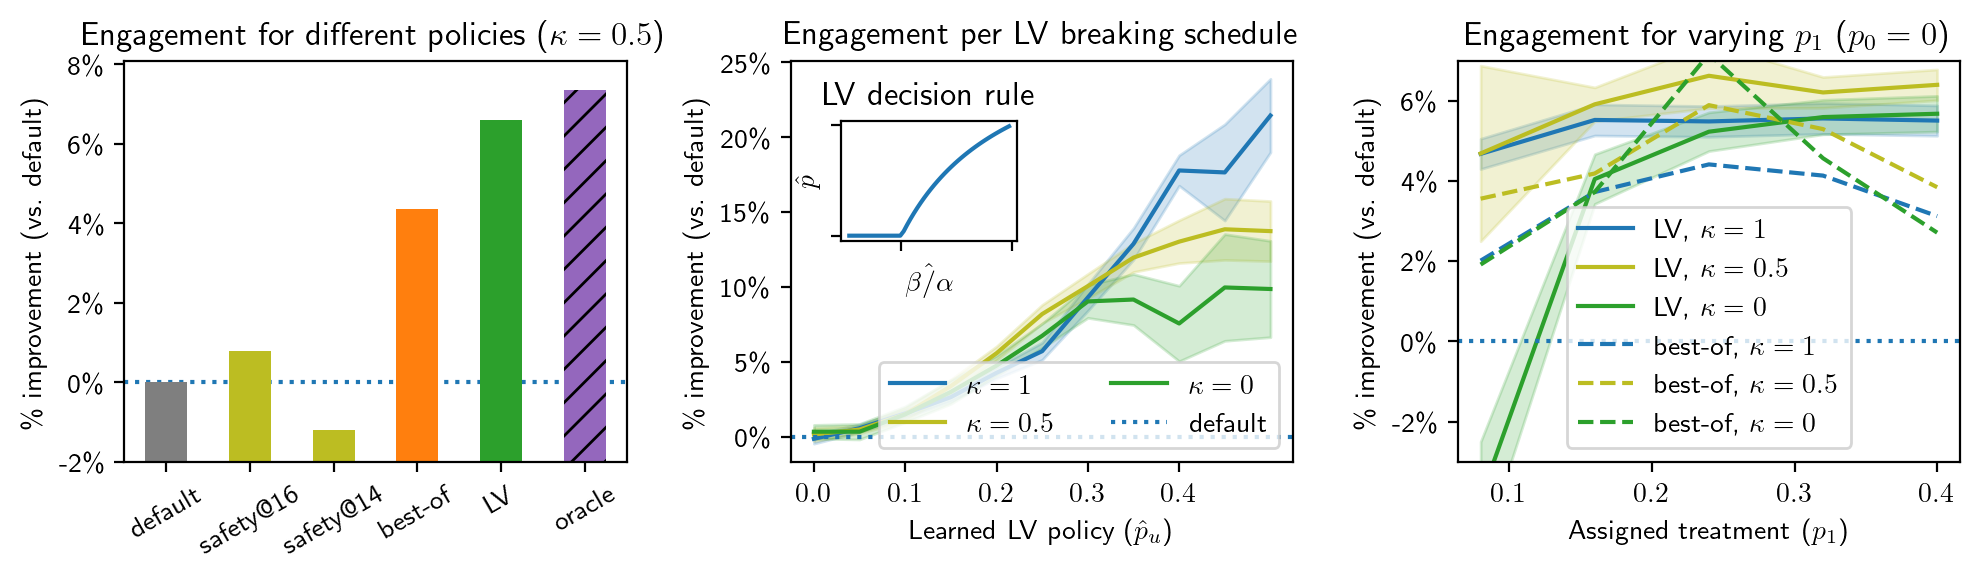

In [49]:
fig,axs=create_fig(1,3,tight_layout=dict(w_pad=2))

selected_simulator = 'discrete'
selected_kappa = param(0.5,'barplot_selected_kappa')
selected_predictor = 'linear_regression'

kappa_colors={
    ('lv_engagement',1.0): 'tab:blue',
    ('lv_engagement',0.5): 'tab:olive',
    ('lv_engagement',0.0): 'tab:green',
    ('argmax',1.0): 'tab:red',
    ('argmax',0.5): 'tab:pink',
    ('argmax',0.0): 'tab:orange',
}

bar_plot_config={
    'default': ((selected_predictor,'myopic'), 'tab:gray', ''),
    f'safety@{selected_safety_threshold_high}': (('none','safety'), 'tab:olive', ''),
    f'safety@{selected_safety_threshold_low}': (('none','safety_low'), 'tab:olive', ''),
    'best-of': ((selected_predictor,'argmax'), 'tab:orange', ''),
    'LV': ((selected_predictor,'lv_engagement'), 'tab:green', ''),
    'oracle': (('oracle','lv_engagement'), 'tab:purple', '//'),
}


assert selected_kappa == safety_selected_kappa

ax=axs[0]
barplot_comparison_df = (
    results_df
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .pivot('user_ind',['predictor','policy'],'rate')
    .mean()
    .pipe(lambda s: s/s.loc[(selected_predictor,'myopic')])
    .loc[([selected_predictor,'oracle'],['myopic','argmax','lv_engagement'])]
)
barplot_comparison_df.loc[('none','safety')]=threshold_res[selected_safety_threshold_high].mean()/myopic_mean
barplot_comparison_df.loc[('none','safety_low')]=threshold_res[selected_safety_threshold_low].mean()/myopic_mean

(
    barplot_comparison_df
    .loc[[t[0] for t in bar_plot_config.values()]]
    .pipe(lambda s: s.plot.bar(
        ax=ax,
        color=[t[1] for t in bar_plot_config.values()],
        hatch=[t[2] for t in bar_plot_config.values()],
        # edgecolor=(1,1,1,0.2),
        # edgecolor=(1,1,1,0.2),
    ))
)
ax.axhline(1,linestyle=':',zorder=-1)
ax.set(
    ylim=(0.98,1+(barplot_comparison_df.max()-1)*1.1),
    xticklabels=[n for n in bar_plot_config],
)
ax.xaxis.set_tick_params(rotation=30)
ax.set(
    title=f'Engagement for different policies ($\kappa={selected_kappa}$)',
    xlabel=None,
)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round((x-1)*100)}\%'))


#
# Engagement vs. p
#

ax=axs[1]
# fig,ax=plt.subplots()
i=0
for selected_kappa in [1.0,0.5,0.0]:
    (
        results_df
        .query('simulator==@selected_simulator and kappa==@selected_kappa and predictor==@selected_predictor')
        .pipe(lambda df: pd.concat(
            [
                (
                    df
                    .pivot('user_ind','policy','rate')
                    .apply(lambda row: row['lv_engagement']/(row['myopic']+1e-5)-1,axis=1)
                    .apply(lambda s: s*100)
                    .rename('gain')
                ),
                (
                    df
                    .query('policy=="lv_engagement"')
                    .set_index('user_ind')
                    ['p_fb']
                ),
            ],
            axis=1,
        ))
        .query('p_fb>1e-5')
        .assign(
            p_group=lambda df: quantize(df['p_fb'], res=0.05)
        )
        .groupby('p_group')
        ['gain']
        .agg([
            ('mean', 'mean'),
            ('ci', lambda s: confidence_interval(s.mean(), s.std(), s.count())),
        ])
        .pipe(lambda df: [
            df['mean'].plot.line(
                ax=ax,
                label=f'$\kappa={selected_kappa:.1g}$',
                color=kappa_colors[('lv_engagement',selected_kappa)],
            ),
            ax.fill_between(
                df.index, 
                df['ci'].map(lambda t: t[0]),
                df['ci'].map(lambda t: t[1]),
                alpha=0.2,
                color=kappa_colors[('lv_engagement',selected_kappa)],
            )
        ])
    )
    i+=1

ax.axhline(0, linestyle=':', label='default')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x)}\%'))
ax.set(
    title='Engagement per LV breaking schedule',
    xlabel=r'Learned LV policy ($\hat{p}_u$)',
    xticks=np.arange(0,0.5,0.1)
)

ax.legend(
    loc='lower right',
    ncol=2,
)


axins = ax.inset_axes([0.1, 0.55, 0.35, 0.3])
ba_theory_vec = np.linspace(1,4)[1:-1]
ab_theory_vec = 1/ba_theory_vec
axins.plot(ba_theory_vec, p_opt_f(ab_theory_vec))
axins.set(
    title='LV decision rule',
    xlabel=r'$\hat{\beta/\alpha}$',
    ylabel=r'$\hat{p}$',
)
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)


#
# Sensitivity
#

ax=axs[2]
i=0
for selected_policy, display_name in [('lv_engagement','LV'), ('argmax','best-of')]:
    for selected_kappa in [1.0,0.5,0.0]:
        # color = kappa_colors[(selected_policy,selected_kappa)]
        color = kappa_colors[('lv_engagement',selected_kappa)]
        linestyle = '-' if selected_policy=='lv_engagement' else '--'
        (
            optimizer_variations_results_df
            .query('predictor=="linear_regression" and mode=="two-treatment" and kappa==@selected_kappa')
            .pivot(
                ['p1','user_ind'],
                'policy',
                'rate',
            )
            .apply(lambda row: row/row['myopic']-1, axis=1)
            .apply(lambda s: s*100)
            [selected_policy]
            .groupby(level=0)
            .agg([
                ('mean', 'mean'),
                ('ci', lambda s: confidence_interval(s.mean(), s.std(), s.count())),
            ])
            # .swaplevel(axis=1)
            # .stack()
            .pipe(lambda df: [
                df['mean'].plot.line(
                    ax=ax,
                    label=f'{display_name}, $\kappa={selected_kappa:.1g}$',
                    color=color,
                    linestyle=linestyle,
                ),
                ax.fill_between(
                    df.index, 
                    df['ci'].map(lambda t: t[0]),
                    df['ci'].map(lambda t: t[1]),
                    alpha=0.2,
                    color=color,
                ) if selected_policy=='lv_engagement' else None
            ])
        )
        i+=1

ax.axhline(0,linestyle=':')
ax.legend()
ax.set(
    # title='Sensitivity to prediction error',
    title='Engagement for varying $p_1$ ($p_0=0$)',
    xlabel='Assigned treatment ($p_1$)',
    ylabel=r'\% improvement - engagement',
    ylim=(-3,7),
)
# ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x)}\%'))

for i,ax in enumerate(axs):
    ax.set(
        ylabel=r'\% improvement (vs. default)',
    )
    
fig.download(f'{INPUT_DATASET}_experiment.pdf')

## Total time

In [50]:
global_end_time = datetime.datetime.now()
print(f'Done ({global_end_time-global_start_time})')
param(round((global_end_time-global_start_time).total_seconds()/60), 'total_simulation_time_minutes') 

Done (0:14:33.162675)


15

### Parameter tracking

In [51]:
param(len(dataset.raw_ratings), 'cf_n_ratings')
param(round(get_param('cf_training_set_size')*100), 'cf_training_set_pct')
param(round((1-get_param('cf_training_set_size'))*100), 'cf_test_set_pct')
param(round(get_param('control_group_weight')*100), 'control_group_weight_pct')
param((100-get_param('control_group_weight_pct'))/(len(treatments)-1), 'treatment_group_weight_pct')
param(len(treatment_datasets[0.0][0]), 'control_group_size')
param(len(treatment_datasets[treatments[-1]][0]), 'treatment_group_size')
param(get_param('main_experiment_treatments')[1:], 'main_experiment_nonzero_treatments')
param(len(get_param('main_experiment_treatments'))-1, 'main_experiment_nonzero_treatments_count')

3

In [52]:
param_tracker.params_dct

{'random_state': 0,
 'cf_training_set_size': 0.3,
 'cf_n_users': 6040,
 'cf_n_items': 3706,
 'cf_n_factors': 8,
 'cf_rmse': 0.9169818212409514,
 'lv_alpha': 1.3,
 'lv_beta': array([0.2, 0.8, 1.8, 3.2, 5. ]),
 'lv_gamma': 0.2,
 'lv_delta': 0.01,
 'stateless_model_tau': 4,
 'kappa_values': [0.0, 0.5, 1.0],
 'discrete_simulation_batch_size': 10,
 'softmax_t': 0.5,
 'simulation_length': 100,
 'evaluation_set_users': 1000,
 'main_experiment_treatments': [0.0, 0.05, 0.1, 0.15],
 'control_group_weight': 0.7,
 'adaptive_policy_selected_kappa': 0.0,
 'adaptive_t0_medium': 5,
 'adaptive_t0_small': 0.5,
 'adaptive_t0_large': 50,
 'sensitivity_analysis_treatments': array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 ]),
 'safety_policy_threshold': 16,
 'safety_policy_threshold_low': 14,
 'barplot_selected_kappa': 0.5,
 'total_simulation_time_minutes': 15,
 'cf_n_ratings': 1000209,
 'cf_training_set_pct': 30,
 'cf_test_set_pct': 70,
 'control_group_weight_pct': 70,
 'treatment_group_weight_pct': 10.0,
 'contr

## Output files

In [53]:
output_dir = f'./output/{INPUT_DATASET}_{RANDOM_STATE}'
os.mkdir(output_dir)

results_df.to_csv(f'{output_dir}/results_df.csv.zip', compression='zip')
optimizer_variations_results_df.to_csv(f'{output_dir}/sensitivity_df.csv.zip', compression='zip')
adaptive_results_df.to_csv(f'{output_dir}/adaptive_results_df.csv.zip', compression='zip')
true_ratings_results_df.to_csv(f'{output_dir}/true_ratings_results_df.csv.zip', compression='zip')

import pickle
pickle.dump(param_tracker.params_dct, open(f'{output_dir}/params.pkl','wb'))
pickle.dump(threshold_res, open(f'{output_dir}/safety.pkl','wb'))


print('Results saved!')

Results saved!
